In [1]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# ResNet50

example image

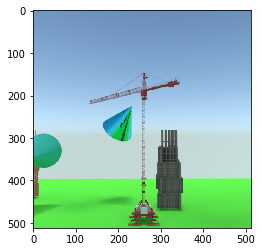

In [2]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [3]:
input_shape = img.shape

In [4]:
img = img.reshape((1,512,512,3))
img.shape

(1, 512, 512, 3)

In [5]:
img = tf.cast(img, dtype=tf.float32)

In [6]:
class_num = 1

In [7]:
input_tensor = layers.Input(input_shape)

load ResNet50

In [8]:
base_model = applications.ResNet50(include_top=False, input_shape=input_shape, weights=None, pooling='avg')
    
x = base_model.output
x = layers.Dense(1000, activation="softmax")(x)
resnet50 = Model(base_model.input, x)

#freeze layer
for layer in resnet50.layers:
    layer.trainable = False

#load pre_trained weight
resnet50.load_weights("resnet50_ImageNet.h5")

#unfreeze layer
for layer in resnet50.layers[:174]:
    layer.trainable = True

In [9]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

extract feature C1~C5

In [10]:
C1 = resnet50.get_layer('pool1_pad').output
C2 = resnet50.get_layer('conv2_block3_out').output
C3 = resnet50.get_layer('conv3_block4_out').output
C4 = resnet50.get_layer('conv4_block6_out').output
C5 = resnet50.get_layer('conv5_block3_out').output

# Feature Pyramid Network

In [11]:
def P5(x, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

def FPN(x, y, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    y = layers.UpSampling2D()(y)
    
    P = layers.Add()([x, y])
    
    return P

In [12]:
P5 = P5(C5)
P4 = FPN(C4, P5)
P3 = FPN(C3, P4)
P2 = FPN(C2, P3)

In [13]:
def FM(x, upsampling, train_bn=True):
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    if upsampling != 1:
        x = layers.Conv2DTranspose(128, (3, 3), strides=(upsampling, upsampling), padding='same')(x)
        x = layers.BatchNormalization()(x, training=train_bn)
        x = layers.Activation('relu')(x)
    
    return x

feature map

In [14]:
FM5 = FM(P5, 8)
FM4 = FM(P4, 4)
FM3 = FM(P3, 2)
FM2 = FM(P2, 1)
FM = layers.concatenate([FM5, FM4, FM3, FM2])
FM.shape

TensorShape([None, 128, 128, 512])

head

In [15]:
def Head(x, train_bn=True):
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

In [16]:
H = Head(FM)
H.shape

TensorShape([None, 128, 128, 512])

resize feature map

In [17]:
def Resize(x, train_bn=True):
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(class_num, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('sigmoid')(x)
    
    return x

In [18]:
output = Resize(H)
output.shape

TensorShape([None, 512, 512, 1])

make model

In [19]:
NADS_Net = Model(resnet50.input, output)
NADS_Net = utils.multi_gpu_model(NADS_Net, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [20]:
NADS_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 1)  36242693    lambda[0][0]                     
                                                                 lambda_1[0][0]             

In [21]:
example = NADS_Net(img)
example.shape

TensorShape([1, 512, 512, 1])

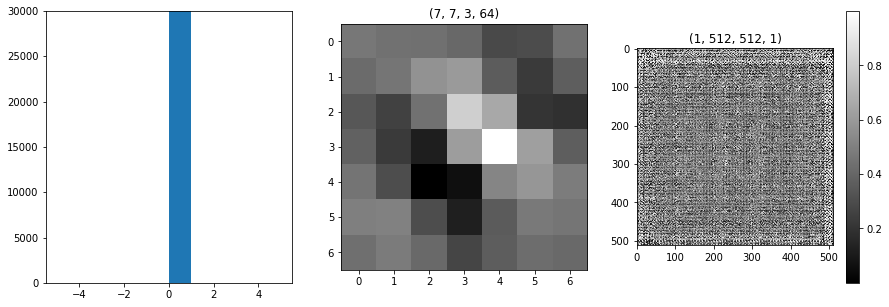

In [22]:
weight = NADS_Net.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 30000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [35]:
HEIGHT = 512
WIDTH = 512

train_paths = glob('C:/Users/IVCL/Desktop/dock6/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock6/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock6/dataset/val/*.png')

In [36]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = glob('C:/Users/IVCL/Desktop/dock6/classify/%s/*.png'%label_name)
    label = plt.imread(label_path[0])
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [37]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [38]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [39]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0)]
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

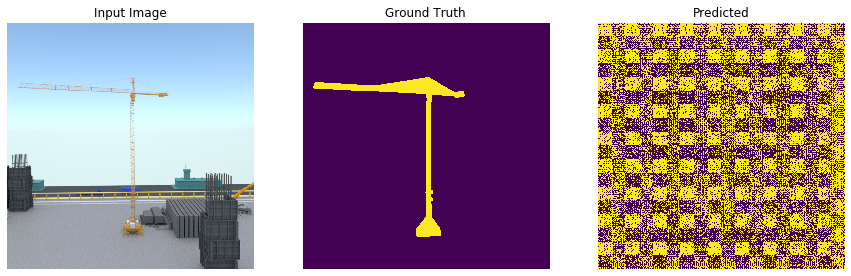

In [40]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(NADS_Net, image, label)

# Define Loss and Optimizer

In [41]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [42]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [43]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, NADS_Net=NADS_Net)

# Training

In [44]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 20
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [45]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [35]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(NADS_Net, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(NADS_Net, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    #train_accuracy.reset_states()
    #train_recall.reset_states()
    val_loss.reset_states()
    #val_accuracy.reset_states()
    #val_recall.reset_states()
    
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1, Step 1, Loss: 0.8064459562301636, Precision: 2.0860469341278076, Recall: 43.977081298828125
Epoch 1, Step 2, Loss: 0.776877224445343, Precision: 3.3307723999023438, Recall: 19.15489387512207
Epoch 1, Step 3, Loss: 0.7122817039489746, Precision: 20.220720291137695, Recall: 49.36030960083008
Epoch 1, Step 4, Loss: 0.6563054919242859, Precision: 40.20030975341797, Recall: 90.8637924194336
Epoch 1, Step 5, Loss: 0.638031005859375, Precision: 37.085235595703125, Recall: 94.5634536743164
Epoch 1, Step 6, Loss: 0.6191980242729187, Precision: 54.359947204589844, Recall: 95.73779296875
Epoch 1, Step 7, Loss: 0.617508053779602, Precision: 52.76268768310547, Recall: 99.5230484008789
Epoch 1, Step 8, Loss: 0.600662112236023, Precision: 56.970394134521484, Recall: 99.96543884277344
Epoch 1, Step 9, Loss: 0.6152828931808472, Precision: 44.22010040283203, Recall: 99.9662857055664
Epoch 1, Step 10, Loss: 0.6186403036117554, Precision: 51.75431442260742, Recall: 99.8605728149414
Epoch 1, Step 

Epoch 1, Step 86, Loss: 0.5582225322723389, Precision: 83.09017944335938, Recall: 99.95256805419922
Epoch 1, Step 87, Loss: 0.5405384302139282, Precision: 85.32526397705078, Recall: 99.95948791503906
Epoch 1, Step 88, Loss: 0.5552613139152527, Precision: 82.74533081054688, Recall: 99.96119689941406
Epoch 1, Step 89, Loss: 0.5425424575805664, Precision: 84.77877807617188, Recall: 99.99467468261719
Epoch 1, Step 90, Loss: 0.5476197600364685, Precision: 84.664306640625, Recall: 99.98835754394531
Epoch 1, Step 91, Loss: 0.5373431444168091, Precision: 85.90859985351562, Recall: 99.98501586914062
Epoch 1, Step 92, Loss: 0.552190899848938, Precision: 84.01555633544922, Recall: 99.92292785644531
Epoch 1, Step 93, Loss: 0.5565751791000366, Precision: 84.10135650634766, Recall: 99.99299621582031
Epoch 1, Step 94, Loss: 0.5586040616035461, Precision: 84.62451171875, Recall: 99.95576477050781
Epoch 1, Step 95, Loss: 0.5561174154281616, Precision: 84.63761138916016, Recall: 99.94429016113281
Epoch 

Epoch 1, Step 168, Loss: 0.5005152821540833, Precision: 93.998291015625, Recall: 99.92927551269531
Epoch 1, Step 169, Loss: 0.5004258155822754, Precision: 91.01201629638672, Recall: 99.95451354980469
Epoch 1, Step 170, Loss: 0.5116629600524902, Precision: 91.03544616699219, Recall: 99.97547912597656
Epoch 1, Step 171, Loss: 0.512968897819519, Precision: 93.99501037597656, Recall: 99.94316101074219
Epoch 1, Step 172, Loss: 0.5217667818069458, Precision: 93.1259536743164, Recall: 99.94783020019531
Epoch 1, Step 173, Loss: 0.5074549913406372, Precision: 93.98916625976562, Recall: 99.89527130126953
Epoch 1, Step 174, Loss: 0.5123609304428101, Precision: 92.26176452636719, Recall: 99.88592529296875
Epoch 1, Step 175, Loss: 0.5107671022415161, Precision: 91.24500274658203, Recall: 99.89995574951172
Epoch 1, Step 176, Loss: 0.5107135772705078, Precision: 93.39139556884766, Recall: 99.88671112060547
Epoch 1, Step 177, Loss: 0.4957805275917053, Precision: 94.66394805908203, Recall: 99.929901123

Epoch 1, Step 250, Loss: 0.47995978593826294, Precision: 96.65764617919922, Recall: 99.83746337890625
Epoch 1, Step 251, Loss: 0.4665217399597168, Precision: 96.29629516601562, Recall: 99.89530944824219
Epoch 1, Step 252, Loss: 0.46348774433135986, Precision: 96.03941345214844, Recall: 99.97486114501953
Epoch 1, Step 253, Loss: 0.47907060384750366, Precision: 94.94819641113281, Recall: 99.92257690429688
Epoch 1, Step 254, Loss: 0.48331427574157715, Precision: 96.27996826171875, Recall: 99.87137603759766
Epoch 1, Step 255, Loss: 0.487930029630661, Precision: 97.5048599243164, Recall: 99.78521728515625
Epoch 1, Step 256, Loss: 0.47770601511001587, Precision: 96.56329345703125, Recall: 99.86908721923828
Epoch 1, Step 257, Loss: 0.47406142950057983, Precision: 94.96844482421875, Recall: 99.96924591064453
Epoch 1, Step 258, Loss: 0.48853230476379395, Precision: 95.21192932128906, Recall: 99.8929443359375
Epoch 1, Step 259, Loss: 0.480417937040329, Precision: 97.68537902832031, Recall: 99.73

Epoch 1, Step 332, Loss: 0.4445722997188568, Precision: 97.52558135986328, Recall: 99.79669952392578
Epoch 1, Step 333, Loss: 0.4409979283809662, Precision: 96.69917297363281, Recall: 99.50980377197266
Epoch 1, Step 334, Loss: 0.45994797348976135, Precision: 96.47318267822266, Recall: 99.92389678955078
Epoch 1, Step 335, Loss: 0.4354246258735657, Precision: 95.58210754394531, Recall: 99.19762420654297
Epoch 1, Step 336, Loss: 0.4397360682487488, Precision: 97.84423828125, Recall: 99.7958755493164
Epoch 1, Step 337, Loss: 0.4460018277168274, Precision: 97.61029815673828, Recall: 99.39327239990234
Epoch 1, Step 338, Loss: 0.443049818277359, Precision: 97.18250274658203, Recall: 99.68303680419922
Epoch 1, Step 339, Loss: 0.4428121745586395, Precision: 94.83624267578125, Recall: 99.91813659667969
Epoch 1, Step 340, Loss: 0.4287351369857788, Precision: 96.0885009765625, Recall: 99.8902359008789
Epoch 1, Step 341, Loss: 0.43500179052352905, Precision: 97.5645751953125, Recall: 99.79891967773

Epoch 2, Step 13, Loss: 0.4098421335220337, Precision: 97.788330078125, Recall: 99.98857879638672
Epoch 2, Step 14, Loss: 0.43076425790786743, Precision: 99.1117172241211, Recall: 99.52825927734375
Epoch 2, Step 15, Loss: 0.42220422625541687, Precision: 98.80876922607422, Recall: 99.40434265136719
Epoch 2, Step 16, Loss: 0.41337788105010986, Precision: 97.99138641357422, Recall: 99.91337585449219
Epoch 2, Step 17, Loss: 0.43412429094314575, Precision: 96.65168762207031, Recall: 100.0
Epoch 2, Step 18, Loss: 0.4071776866912842, Precision: 97.81204223632812, Recall: 99.48644256591797
Epoch 2, Step 19, Loss: 0.4101146459579468, Precision: 99.04015350341797, Recall: 99.60562896728516
Epoch 2, Step 20, Loss: 0.41399917006492615, Precision: 97.53411102294922, Recall: 99.55033874511719
Epoch 2, Step 21, Loss: 0.4125076234340668, Precision: 98.1322021484375, Recall: 99.64285278320312
Epoch 2, Step 22, Loss: 0.4070485532283783, Precision: 97.66136932373047, Recall: 99.61470794677734
Epoch 2, St

Epoch 2, Step 96, Loss: 0.39877814054489136, Precision: 98.81432342529297, Recall: 99.74186706542969
Epoch 2, Step 97, Loss: 0.3832087516784668, Precision: 98.23690795898438, Recall: 99.61235809326172
Epoch 2, Step 98, Loss: 0.3961429297924042, Precision: 97.69005584716797, Recall: 99.83565521240234
Epoch 2, Step 99, Loss: 0.37612995505332947, Precision: 98.55729675292969, Recall: 99.8434066772461
Epoch 2, Step 100, Loss: 0.3837236166000366, Precision: 98.2342300415039, Recall: 99.8514175415039
Epoch 2, Step 101, Loss: 0.3949190676212311, Precision: 97.42898559570312, Recall: 99.95516204833984
Epoch 2, Step 102, Loss: 0.3930116295814514, Precision: 97.93334197998047, Recall: 99.79437255859375
Epoch 2, Step 103, Loss: 0.3774479925632477, Precision: 98.92548370361328, Recall: 99.77671813964844
Epoch 2, Step 104, Loss: 0.3729743957519531, Precision: 98.58928680419922, Recall: 99.85762023925781
Epoch 2, Step 105, Loss: 0.38506537675857544, Precision: 98.76603698730469, Recall: 99.732101440

Epoch 2, Step 178, Loss: 0.3549368381500244, Precision: 99.34583282470703, Recall: 99.10272216796875
Epoch 2, Step 179, Loss: 0.37213417887687683, Precision: 98.8662109375, Recall: 99.4979476928711
Epoch 2, Step 180, Loss: 0.3647152781486511, Precision: 96.91587829589844, Recall: 99.9008560180664
Epoch 2, Step 181, Loss: 0.37679827213287354, Precision: 95.8077392578125, Recall: 100.0
Epoch 2, Step 182, Loss: 0.3531568646430969, Precision: 98.06424713134766, Recall: 99.89165496826172
Epoch 2, Step 183, Loss: 0.36047306656837463, Precision: 99.15464782714844, Recall: 99.63772583007812
Epoch 2, Step 184, Loss: 0.3551711142063141, Precision: 98.64301300048828, Recall: 99.11707305908203
Epoch 2, Step 185, Loss: 0.3492673933506012, Precision: 99.11133575439453, Recall: 99.5536880493164
Epoch 2, Step 186, Loss: 0.3541998267173767, Precision: 98.50033569335938, Recall: 99.6908187866211
Epoch 2, Step 187, Loss: 0.3656042218208313, Precision: 98.166015625, Recall: 99.2309799194336
Epoch 2, Step 

Epoch 2, Step 260, Loss: 0.3477383255958557, Precision: 98.86039733886719, Recall: 99.81076049804688
Epoch 2, Step 261, Loss: 0.34733855724334717, Precision: 98.66320037841797, Recall: 99.69232940673828
Epoch 2, Step 262, Loss: 0.32944750785827637, Precision: 98.4399642944336, Recall: 99.89871978759766
Epoch 2, Step 263, Loss: 0.3361572027206421, Precision: 99.18032836914062, Recall: 99.85543060302734
Epoch 2, Step 264, Loss: 0.3254130184650421, Precision: 99.25086212158203, Recall: 99.77407836914062
Epoch 2, Step 265, Loss: 0.32726767659187317, Precision: 99.0069351196289, Recall: 99.84352111816406
Epoch 2, Step 266, Loss: 0.33206433057785034, Precision: 98.56941986083984, Recall: 99.94879913330078
Epoch 2, Step 267, Loss: 0.3327711820602417, Precision: 98.64849090576172, Recall: 99.7798843383789
Epoch 2, Step 268, Loss: 0.3433719873428345, Precision: 99.33177185058594, Recall: 99.53697204589844
Epoch 2, Step 269, Loss: 0.3360954523086548, Precision: 99.03334045410156, Recall: 99.8375

Epoch 2, Step 342, Loss: 0.31797292828559875, Precision: 99.00238800048828, Recall: 99.82286071777344
Epoch 2, Step 343, Loss: 0.3124539256095886, Precision: 99.28411865234375, Recall: 99.78128051757812
Epoch 2, Step 344, Loss: 0.307608425617218, Precision: 99.10710144042969, Recall: 99.80957794189453
Epoch 2, Step 345, Loss: 0.3168278932571411, Precision: 98.68833923339844, Recall: 99.89403533935547
Epoch 2, Step 346, Loss: 0.3122512996196747, Precision: 98.7428970336914, Recall: 99.90707397460938
Epoch 2, Step 347, Loss: 0.31828632950782776, Precision: 99.20479583740234, Recall: 99.7313461303711
Epoch 2, Step 348, Loss: 0.30610013008117676, Precision: 99.27581787109375, Recall: 99.68089294433594
Epoch 2, Step 349, Loss: 0.3089383840560913, Precision: 98.77096557617188, Recall: 99.86193084716797
Epoch 2, Step 350, Loss: 0.322346568107605, Precision: 99.03948211669922, Recall: 99.83625793457031
Epoch 2, Step 351, Loss: 0.31626370549201965, Precision: 99.09494018554688, Recall: 99.80876

Epoch 3, Step 23, Loss: 0.30086371302604675, Precision: 99.12164306640625, Recall: 99.85252380371094
Epoch 3, Step 24, Loss: 0.2863774597644806, Precision: 98.89566802978516, Recall: 99.94393920898438
Epoch 3, Step 25, Loss: 0.30987560749053955, Precision: 99.20628356933594, Recall: 99.82708740234375
Epoch 3, Step 26, Loss: 0.2921770215034485, Precision: 99.43097686767578, Recall: 99.76021575927734
Epoch 3, Step 27, Loss: 0.3073732256889343, Precision: 99.52926635742188, Recall: 99.41227722167969
Epoch 3, Step 28, Loss: 0.288923054933548, Precision: 98.98046875, Recall: 99.83222198486328
Epoch 3, Step 29, Loss: 0.29814764857292175, Precision: 98.85442352294922, Recall: 99.76617431640625
Epoch 3, Step 30, Loss: 0.2979360520839691, Precision: 99.22320556640625, Recall: 99.81766510009766
Epoch 3, Step 31, Loss: 0.29373899102211, Precision: 99.16136169433594, Recall: 99.91011047363281
Epoch 3, Step 32, Loss: 0.2947469651699066, Precision: 99.36131286621094, Recall: 99.62796020507812
Epoch 

Epoch 3, Step 105, Loss: 0.2805282175540924, Precision: 99.13583374023438, Recall: 99.83883666992188
Epoch 3, Step 106, Loss: 0.2702258825302124, Precision: 98.99500274658203, Recall: 99.82672119140625
Epoch 3, Step 107, Loss: 0.2667117714881897, Precision: 99.25115966796875, Recall: 99.83646392822266
Epoch 3, Step 108, Loss: 0.2883480191230774, Precision: 99.34327697753906, Recall: 99.76722717285156
Epoch 3, Step 109, Loss: 0.275185763835907, Precision: 98.97811889648438, Recall: 99.7208023071289
Epoch 3, Step 110, Loss: 0.2737416625022888, Precision: 99.06212615966797, Recall: 99.78814697265625
Epoch 3, Step 111, Loss: 0.27068445086479187, Precision: 99.61077117919922, Recall: 99.49781036376953
Epoch 3, Step 112, Loss: 0.280053973197937, Precision: 99.487548828125, Recall: 99.5202407836914
Epoch 3, Step 113, Loss: 0.27645978331565857, Precision: 99.27938842773438, Recall: 99.6628189086914
Epoch 3, Step 114, Loss: 0.2849824130535126, Precision: 99.17528533935547, Recall: 99.6366043090

Epoch 3, Step 187, Loss: 0.26295724511146545, Precision: 99.66838073730469, Recall: 99.61851501464844
Epoch 3, Step 188, Loss: 0.2542005479335785, Precision: 99.04902648925781, Recall: 99.8402328491211
Epoch 3, Step 189, Loss: 0.2651713192462921, Precision: 98.7101821899414, Recall: 99.90010070800781
Epoch 3, Step 190, Loss: 0.2747914791107178, Precision: 98.5914306640625, Recall: 99.8132553100586
Epoch 3, Step 191, Loss: 0.2660391926765442, Precision: 99.23045349121094, Recall: 99.71941375732422
Epoch 3, Step 192, Loss: 0.2665002942085266, Precision: 99.11390686035156, Recall: 99.82968139648438
Epoch 3, Step 193, Loss: 0.2573951184749603, Precision: 99.60304260253906, Recall: 99.3857650756836
Epoch 3, Step 194, Loss: 0.26251575350761414, Precision: 99.6425552368164, Recall: 99.48737335205078
Epoch 3, Step 195, Loss: 0.25762832164764404, Precision: 99.31626892089844, Recall: 99.84137725830078
Epoch 3, Step 196, Loss: 0.26552775502204895, Precision: 99.2239990234375, Recall: 99.68394470

Epoch 3, Step 269, Loss: 0.24183335900306702, Precision: 99.66789245605469, Recall: 99.33797454833984
Epoch 3, Step 270, Loss: 0.2538987398147583, Precision: 99.34557342529297, Recall: 99.85797119140625
Epoch 3, Step 271, Loss: 0.24530205130577087, Precision: 99.20726776123047, Recall: 99.7808837890625
Epoch 3, Step 272, Loss: 0.24550822377204895, Precision: 99.15310668945312, Recall: 99.83436584472656
Epoch 3, Step 273, Loss: 0.23883460462093353, Precision: 99.19462585449219, Recall: 99.84327697753906
Epoch 3, Step 274, Loss: 0.2439441829919815, Precision: 99.49290466308594, Recall: 99.6534194946289
Epoch 3, Step 275, Loss: 0.24737821519374847, Precision: 99.4515151977539, Recall: 99.74459838867188
Epoch 3, Step 276, Loss: 0.23600585758686066, Precision: 99.58301544189453, Recall: 99.57788848876953
Epoch 3, Step 277, Loss: 0.249191552400589, Precision: 99.318359375, Recall: 99.62461853027344
Epoch 3, Step 278, Loss: 0.24746155738830566, Precision: 99.2090072631836, Recall: 99.87699127

Epoch 3, Step 350, Loss: 0.23301422595977783, Precision: 99.4290771484375, Recall: 99.79625701904297
Epoch 3, Step 351, Loss: 0.22541218996047974, Precision: 98.9129867553711, Recall: 99.85944366455078
Epoch 3, Step 352, Loss: 0.22989371418952942, Precision: 99.08419036865234, Recall: 99.89278411865234
Epoch 3, Step 353, Loss: 0.2227250337600708, Precision: 99.48543548583984, Recall: 99.70091247558594
Epoch 3, Step 354, Loss: 0.23696154356002808, Precision: 99.43836212158203, Recall: 99.75750732421875
Epoch 3, Step 355, Loss: 0.2399122714996338, Precision: 99.37832641601562, Recall: 99.81192779541016
Epoch 3, Step 356, Loss: 0.23746520280838013, Precision: 99.43338775634766, Recall: 99.78131103515625
Epoch 3, Step 357, Loss: 0.23073604702949524, Precision: 99.18887329101562, Recall: 99.86491394042969
Epoch 3, Step 358, Loss: 0.22381138801574707, Precision: 99.25357055664062, Recall: 99.7695541381836
Epoch 3, Step 359, Loss: 0.23429107666015625, Precision: 99.39513397216797, Recall: 99.

Epoch 4, Step 31, Loss: 0.22110430896282196, Precision: 99.55445098876953, Recall: 99.67854309082031
Epoch 4, Step 32, Loss: 0.21953928470611572, Precision: 99.27053833007812, Recall: 99.71328735351562
Epoch 4, Step 33, Loss: 0.213969886302948, Precision: 99.29391479492188, Recall: 99.8197250366211
Epoch 4, Step 34, Loss: 0.21471434831619263, Precision: 99.38614654541016, Recall: 99.81562805175781
Epoch 4, Step 35, Loss: 0.20952127873897552, Precision: 99.42916107177734, Recall: 99.85538482666016
Epoch 4, Step 36, Loss: 0.20718137919902802, Precision: 99.45451354980469, Recall: 99.80274200439453
Epoch 4, Step 37, Loss: 0.22270339727401733, Precision: 99.54235076904297, Recall: 99.74600982666016
Epoch 4, Step 38, Loss: 0.20913492143154144, Precision: 99.75656127929688, Recall: 99.66365051269531
Epoch 4, Step 39, Loss: 0.20891261100769043, Precision: 99.28692626953125, Recall: 99.86068725585938
Epoch 4, Step 40, Loss: 0.21685078740119934, Precision: 98.8864517211914, Recall: 99.895500183

Epoch 4, Step 113, Loss: 0.19691102206707, Precision: 99.72798919677734, Recall: 99.43746948242188
Epoch 4, Step 114, Loss: 0.21801400184631348, Precision: 99.44053649902344, Recall: 99.81281280517578
Epoch 4, Step 115, Loss: 0.21387052536010742, Precision: 99.54859924316406, Recall: 99.71363830566406
Epoch 4, Step 116, Loss: 0.197940856218338, Precision: 99.47581481933594, Recall: 99.67756652832031
Epoch 4, Step 117, Loss: 0.2078169286251068, Precision: 99.1216049194336, Recall: 99.82962036132812
Epoch 4, Step 118, Loss: 0.1988551914691925, Precision: 99.21001434326172, Recall: 99.80797576904297
Epoch 4, Step 119, Loss: 0.20980873703956604, Precision: 99.36026763916016, Recall: 99.82410430908203
Epoch 4, Step 120, Loss: 0.20180557668209076, Precision: 99.44099426269531, Recall: 99.83963775634766
Epoch 4, Step 121, Loss: 0.20162011682987213, Precision: 99.58622741699219, Recall: 99.6205825805664
Epoch 4, Step 122, Loss: 0.19476266205310822, Precision: 99.45298767089844, Recall: 99.6199

Epoch 4, Step 194, Loss: 0.1959414780139923, Precision: 99.69044494628906, Recall: 99.53952026367188
Epoch 4, Step 195, Loss: 0.1863439977169037, Precision: 99.5291748046875, Recall: 99.68221282958984
Epoch 4, Step 196, Loss: 0.20212383568286896, Precision: 99.58296203613281, Recall: 99.74638366699219
Epoch 4, Step 197, Loss: 0.19397540390491486, Precision: 99.17942810058594, Recall: 99.79816436767578
Epoch 4, Step 198, Loss: 0.19248118996620178, Precision: 99.42729187011719, Recall: 99.7689437866211
Epoch 4, Step 199, Loss: 0.188167005777359, Precision: 99.65375518798828, Recall: 99.67533111572266
Epoch 4, Step 200, Loss: 0.18534071743488312, Precision: 99.6439437866211, Recall: 99.71495056152344
Epoch 4, Step 201, Loss: 0.19428521394729614, Precision: 99.70793151855469, Recall: 99.65838623046875
Epoch 4, Step 202, Loss: 0.1931961476802826, Precision: 99.3001480102539, Recall: 99.84701538085938
Epoch 4, Step 203, Loss: 0.19635999202728271, Precision: 99.13488006591797, Recall: 99.8811

Epoch 4, Step 276, Loss: 0.17743410170078278, Precision: 99.48600769042969, Recall: 99.77680206298828
Epoch 4, Step 277, Loss: 0.1835286021232605, Precision: 99.7733383178711, Recall: 99.40189361572266
Epoch 4, Step 278, Loss: 0.17674681544303894, Precision: 99.65326690673828, Recall: 99.71089172363281
Epoch 4, Step 279, Loss: 0.19128316640853882, Precision: 99.4587173461914, Recall: 99.66386413574219
Epoch 4, Step 280, Loss: 0.18508805334568024, Precision: 99.1987075805664, Recall: 99.84390258789062
Epoch 4, Step 281, Loss: 0.1902785748243332, Precision: 99.16716003417969, Recall: 99.84552764892578
Epoch 4, Step 282, Loss: 0.18129023909568787, Precision: 99.7107925415039, Recall: 99.73434448242188
Epoch 4, Step 283, Loss: 0.1889294683933258, Precision: 99.73884582519531, Recall: 99.70991516113281
Epoch 4, Step 284, Loss: 0.17840589582920074, Precision: 99.56037902832031, Recall: 99.84374237060547
Epoch 4, Step 285, Loss: 0.18143318593502045, Precision: 99.36878967285156, Recall: 99.89

Epoch 4, Step 358, Loss: 0.18103472888469696, Precision: 99.44448852539062, Recall: 99.66595458984375
Epoch 4, Step 359, Loss: 0.18321527540683746, Precision: 99.58973693847656, Recall: 99.65386962890625
Epoch 4, Step 360, Loss: 0.17783254384994507, Precision: 98.97867584228516, Recall: 99.8885726928711
Epoch 4, Step 361, Loss: 0.1715000420808792, Precision: 99.3990478515625, Recall: 99.72808074951172
Epoch 4, Step 362, Loss: 0.17045050859451294, Precision: 99.53938293457031, Recall: 99.70011901855469
Epoch 4, Step 363, Loss: 0.17043854296207428, Precision: 99.39449310302734, Recall: 99.65065002441406
Epoch 4, Step 364, Loss: 0.1726623773574829, Precision: 99.60213470458984, Recall: 99.79148864746094
Epoch 4, Step 365, Loss: 0.17223897576332092, Precision: 99.5682601928711, Recall: 99.5743179321289
Epoch 4, Step 366, Loss: 0.16380296647548676, Precision: 99.6429443359375, Recall: 99.84595489501953
Epoch 4, Step 367, Loss: 0.16914352774620056, Precision: 99.10151672363281, Recall: 99.90

Epoch 5, Step 39, Loss: 0.15590694546699524, Precision: 99.37159729003906, Recall: 99.81610107421875
Epoch 5, Step 40, Loss: 0.16435052454471588, Precision: 99.55435943603516, Recall: 99.70043182373047
Epoch 5, Step 41, Loss: 0.17070013284683228, Precision: 99.2953109741211, Recall: 99.7934341430664
Epoch 5, Step 42, Loss: 0.16390636563301086, Precision: 99.56859588623047, Recall: 99.75650024414062
Epoch 5, Step 43, Loss: 0.16389423608779907, Precision: 99.59982299804688, Recall: 99.70417785644531
Epoch 5, Step 44, Loss: 0.16897553205490112, Precision: 99.54334259033203, Recall: 99.58598327636719
Epoch 5, Step 45, Loss: 0.16787682473659515, Precision: 99.34137725830078, Recall: 99.81388092041016
Epoch 5, Step 46, Loss: 0.15553516149520874, Precision: 99.48564147949219, Recall: 99.62992858886719
Epoch 5, Step 47, Loss: 0.16622918844223022, Precision: 99.79107666015625, Recall: 99.57006072998047
Epoch 5, Step 48, Loss: 0.15583747625350952, Precision: 99.65001678466797, Recall: 99.6500167

Epoch 5, Step 121, Loss: 0.15414828062057495, Precision: 99.26713562011719, Recall: 99.80984497070312
Epoch 5, Step 122, Loss: 0.1510012149810791, Precision: 99.3648910522461, Recall: 99.8309326171875
Epoch 5, Step 123, Loss: 0.15889771282672882, Precision: 99.4090347290039, Recall: 99.76412200927734
Epoch 5, Step 124, Loss: 0.1550876498222351, Precision: 99.51532745361328, Recall: 99.71468353271484
Epoch 5, Step 125, Loss: 0.15489685535430908, Precision: 99.7505874633789, Recall: 99.62332916259766
Epoch 5, Step 126, Loss: 0.15948271751403809, Precision: 99.69564819335938, Recall: 99.5647964477539
Epoch 5, Step 127, Loss: 0.15982142090797424, Precision: 99.71681213378906, Recall: 99.64798736572266
Epoch 5, Step 128, Loss: 0.1553611159324646, Precision: 99.3893814086914, Recall: 99.85128021240234
Epoch 5, Step 129, Loss: 0.1564147025346756, Precision: 99.31047821044922, Recall: 99.92291259765625
Epoch 5, Step 130, Loss: 0.15648844838142395, Precision: 99.50634765625, Recall: 99.74295043

Epoch 5, Step 203, Loss: 0.14380580186843872, Precision: 99.22224426269531, Recall: 99.89448547363281
Epoch 5, Step 204, Loss: 0.1564822793006897, Precision: 99.67731475830078, Recall: 99.40467071533203
Epoch 5, Step 205, Loss: 0.1449204981327057, Precision: 99.46353149414062, Recall: 99.66260528564453
Epoch 5, Step 206, Loss: 0.14889973402023315, Precision: 99.7197036743164, Recall: 99.53802490234375
Epoch 5, Step 207, Loss: 0.14331939816474915, Precision: 99.68535614013672, Recall: 99.47669982910156
Epoch 5, Step 208, Loss: 0.1502511203289032, Precision: 99.27497863769531, Recall: 99.73097229003906
Epoch 5, Step 209, Loss: 0.1467956304550171, Precision: 99.45748138427734, Recall: 99.62752532958984
Epoch 5, Step 210, Loss: 0.145823135972023, Precision: 99.3798828125, Recall: 99.76058197021484
Epoch 5, Step 211, Loss: 0.15110689401626587, Precision: 99.38704681396484, Recall: 99.75115966796875
Epoch 5, Step 212, Loss: 0.14591193199157715, Precision: 99.63277435302734, Recall: 99.602798

Epoch 5, Step 284, Loss: 0.14025169610977173, Precision: 99.4532470703125, Recall: 99.76316833496094
Epoch 5, Step 285, Loss: 0.139847069978714, Precision: 99.623779296875, Recall: 99.72834777832031
Epoch 5, Step 286, Loss: 0.14407584071159363, Precision: 99.77519226074219, Recall: 99.63265228271484
Epoch 5, Step 287, Loss: 0.1385991871356964, Precision: 99.46223449707031, Recall: 99.70649719238281
Epoch 5, Step 288, Loss: 0.14896774291992188, Precision: 99.87454986572266, Recall: 99.4752197265625
Epoch 5, Step 289, Loss: 0.1430267095565796, Precision: 99.6008529663086, Recall: 99.76012420654297
Epoch 5, Step 290, Loss: 0.13821932673454285, Precision: 99.45526885986328, Recall: 99.79206085205078
Epoch 5, Step 291, Loss: 0.13806630671024323, Precision: 99.4010238647461, Recall: 99.8927230834961
Epoch 5, Step 292, Loss: 0.14134836196899414, Precision: 99.36039733886719, Recall: 99.87535095214844
Epoch 5, Step 293, Loss: 0.13905632495880127, Precision: 99.75975036621094, Recall: 99.526763

Epoch 5, Step 366, Loss: 0.1357826292514801, Precision: 99.6327133178711, Recall: 99.59352111816406
Epoch 5, Step 367, Loss: 0.13571001589298248, Precision: 99.51795959472656, Recall: 99.35394287109375
Epoch 5, Step 368, Loss: 0.12730827927589417, Precision: 99.67084503173828, Recall: 99.3697280883789
Epoch 5, Step 369, Loss: 0.13967323303222656, Precision: 99.41262817382812, Recall: 99.64366149902344
Epoch 5, Step 370, Loss: 0.12612532079219818, Precision: 99.52787017822266, Recall: 99.63915252685547
Epoch 5, Step 371, Loss: 0.137961745262146, Precision: 99.3638916015625, Recall: 99.77241516113281
Epoch 5, Step 372, Loss: 0.137181356549263, Precision: 99.20791625976562, Recall: 99.80789947509766
Epoch 5, Step 373, Loss: 0.126121386885643, Precision: 99.4053726196289, Recall: 99.8249740600586
Epoch 5, Step 374, Loss: 0.12909060716629028, Precision: 99.38633728027344, Recall: 99.7703857421875
Epoch 5, Step 375, Loss: 0.13555367290973663, Precision: 99.83881378173828, Recall: 99.34509277

Epoch 6, Step 47, Loss: 0.1270037442445755, Precision: 99.3355712890625, Recall: 99.93753051757812
Epoch 6, Step 48, Loss: 0.12209799885749817, Precision: 99.50621032714844, Recall: 99.83123779296875
Epoch 6, Step 49, Loss: 0.12599880993366241, Precision: 99.7796401977539, Recall: 99.73690795898438
Epoch 6, Step 50, Loss: 0.12809190154075623, Precision: 99.81124877929688, Recall: 99.54560089111328
Epoch 6, Step 51, Loss: 0.12648919224739075, Precision: 99.67241668701172, Recall: 99.72896575927734
Epoch 6, Step 52, Loss: 0.1200195699930191, Precision: 99.75601959228516, Recall: 99.76119995117188
Epoch 6, Step 53, Loss: 0.12432174384593964, Precision: 99.46768188476562, Recall: 99.74775695800781
Epoch 6, Step 54, Loss: 0.1228010505437851, Precision: 99.59455108642578, Recall: 99.79685974121094
Epoch 6, Step 55, Loss: 0.12684108316898346, Precision: 99.60897827148438, Recall: 99.72404479980469
Epoch 6, Step 56, Loss: 0.12637585401535034, Precision: 99.69644927978516, Recall: 99.7279891967

Epoch 6, Step 129, Loss: 0.11604644358158112, Precision: 99.74885559082031, Recall: 99.67266845703125
Epoch 6, Step 130, Loss: 0.11334635317325592, Precision: 99.68301391601562, Recall: 99.73320007324219
Epoch 6, Step 131, Loss: 0.12570178508758545, Precision: 99.53453826904297, Recall: 99.79259490966797
Epoch 6, Step 132, Loss: 0.12299413233995438, Precision: 99.5301742553711, Recall: 99.80481719970703
Epoch 6, Step 133, Loss: 0.12399892508983612, Precision: 99.52364349365234, Recall: 99.83379364013672
Epoch 6, Step 134, Loss: 0.11517715454101562, Precision: 99.70503234863281, Recall: 99.59286499023438
Epoch 6, Step 135, Loss: 0.11473269760608673, Precision: 99.59375, Recall: 99.70421600341797
Epoch 6, Step 136, Loss: 0.13174748420715332, Precision: 99.796630859375, Recall: 99.57483673095703
Epoch 6, Step 137, Loss: 0.120538130402565, Precision: 99.53015899658203, Recall: 99.81534576416016
Epoch 6, Step 138, Loss: 0.1169208288192749, Precision: 99.47843170166016, Recall: 99.8122863769

Epoch 6, Step 210, Loss: 0.10927436500787735, Precision: 99.61570739746094, Recall: 99.78379821777344
Epoch 6, Step 211, Loss: 0.11203280091285706, Precision: 99.65950775146484, Recall: 99.82080841064453
Epoch 6, Step 212, Loss: 0.11547846347093582, Precision: 99.68709564208984, Recall: 99.61565399169922
Epoch 6, Step 213, Loss: 0.11558549106121063, Precision: 99.6982192993164, Recall: 99.58062744140625
Epoch 6, Step 214, Loss: 0.10970160365104675, Precision: 99.70877075195312, Recall: 99.80565643310547
Epoch 6, Step 215, Loss: 0.11804889887571335, Precision: 99.45297241210938, Recall: 99.80750274658203
Epoch 6, Step 216, Loss: 0.11546465754508972, Precision: 99.54639434814453, Recall: 99.91544342041016
Epoch 6, Step 217, Loss: 0.10989266633987427, Precision: 99.55865478515625, Recall: 99.8033676147461
Epoch 6, Step 218, Loss: 0.11336621642112732, Precision: 99.71488952636719, Recall: 99.7633056640625
Epoch 6, Step 219, Loss: 0.10712139308452606, Precision: 99.84410095214844, Recall: 9

Epoch 6, Step 291, Loss: 0.10563621670007706, Precision: 99.56726837158203, Recall: 99.81646728515625
Epoch 6, Step 292, Loss: 0.10851389169692993, Precision: 99.63494873046875, Recall: 99.82930755615234
Epoch 6, Step 293, Loss: 0.11049041152000427, Precision: 99.69099426269531, Recall: 99.63858795166016
Epoch 6, Step 294, Loss: 0.10884960740804672, Precision: 99.74234771728516, Recall: 99.58589935302734
Epoch 6, Step 295, Loss: 0.11187684535980225, Precision: 99.65576171875, Recall: 99.62147521972656
Epoch 6, Step 296, Loss: 0.10885336995124817, Precision: 99.60255432128906, Recall: 99.68303680419922
Epoch 6, Step 297, Loss: 0.10694897174835205, Precision: 99.53334045410156, Recall: 99.8696060180664
Epoch 6, Step 298, Loss: 0.1090870350599289, Precision: 99.5411376953125, Recall: 99.85295867919922
Epoch 6, Step 299, Loss: 0.10759440809488297, Precision: 99.55720520019531, Recall: 99.6764907836914
Epoch 6, Step 300, Loss: 0.10443226993083954, Precision: 99.9014892578125, Recall: 99.623

Epoch 6, Step 372, Loss: 0.10009113699197769, Precision: 99.60176849365234, Recall: 99.7650375366211
Epoch 6, Step 373, Loss: 0.10323277115821838, Precision: 99.43546295166016, Recall: 99.7950668334961
Epoch 6, Step 374, Loss: 0.0987938866019249, Precision: 99.52909088134766, Recall: 99.70124053955078
Epoch 6, Step 375, Loss: 0.09905524551868439, Precision: 99.81884765625, Recall: 99.54835510253906
Epoch 6, Step 376, Loss: 0.0982678160071373, Precision: 99.7822036743164, Recall: 99.51900482177734
Epoch 6, Step 377, Loss: 0.1068626195192337, Precision: 99.64839935302734, Recall: 99.62092590332031
Epoch 6, Step 378, Loss: 0.09679865092039108, Precision: 99.63887786865234, Recall: 99.71780395507812
Epoch 6, Step 379, Loss: 0.09944932162761688, Precision: 99.35114288330078, Recall: 99.89669799804688
Epoch 6, Step 380, Loss: 0.10560278594493866, Precision: 99.34866333007812, Recall: 99.81595611572266
Epoch 6, Step 381, Loss: 0.10716113448143005, Precision: 99.60054016113281, Recall: 99.6289

Epoch 7, Step 53, Loss: 0.09386861324310303, Precision: 99.81279754638672, Recall: 99.62630462646484
Epoch 7, Step 54, Loss: 0.10105693340301514, Precision: 99.52197265625, Recall: 99.75714111328125
Epoch 7, Step 55, Loss: 0.10305936634540558, Precision: 99.51971435546875, Recall: 99.75927734375
Epoch 7, Step 56, Loss: 0.09945344924926758, Precision: 99.68388366699219, Recall: 99.68388366699219
Epoch 7, Step 57, Loss: 0.09706494212150574, Precision: 99.70137023925781, Recall: 99.70720672607422
Epoch 7, Step 58, Loss: 0.09293350577354431, Precision: 99.68993377685547, Recall: 99.72541046142578
Epoch 7, Step 59, Loss: 0.09517619013786316, Precision: 99.55462646484375, Recall: 99.735595703125
Epoch 7, Step 60, Loss: 0.10090276598930359, Precision: 99.5385513305664, Recall: 99.73197937011719
Epoch 7, Step 61, Loss: 0.10055693984031677, Precision: 99.67915344238281, Recall: 99.67915344238281
Epoch 7, Step 62, Loss: 0.09712059795856476, Precision: 99.609375, Recall: 99.67426300048828
Epoch 7

Epoch 7, Step 135, Loss: 0.10029654204845428, Precision: 99.6966781616211, Recall: 99.6966781616211
Epoch 7, Step 136, Loss: 0.08888235688209534, Precision: 99.83671569824219, Recall: 99.48139190673828
Epoch 7, Step 137, Loss: 0.09252124279737473, Precision: 99.75360870361328, Recall: 99.718505859375
Epoch 7, Step 138, Loss: 0.09422731399536133, Precision: 99.435302734375, Recall: 99.79671478271484
Epoch 7, Step 139, Loss: 0.10159692913293839, Precision: 99.62342071533203, Recall: 99.86273193359375
Epoch 7, Step 140, Loss: 0.08845816552639008, Precision: 99.46993255615234, Recall: 99.87328338623047
Epoch 7, Step 141, Loss: 0.09565814584493637, Precision: 99.53907775878906, Recall: 99.69892120361328
Epoch 7, Step 142, Loss: 0.09051889181137085, Precision: 99.86257934570312, Recall: 99.64348602294922
Epoch 7, Step 143, Loss: 0.08824504911899567, Precision: 99.8990707397461, Recall: 99.3077163696289
Epoch 7, Step 144, Loss: 0.09180301427841187, Precision: 99.52076721191406, Recall: 99.662

Epoch 7, Step 216, Loss: 0.09590734541416168, Precision: 99.82356262207031, Recall: 99.44075775146484
Epoch 7, Step 217, Loss: 0.09941013157367706, Precision: 99.79131317138672, Recall: 99.60234832763672
Epoch 7, Step 218, Loss: 0.09025806933641434, Precision: 99.88115692138672, Recall: 99.0509262084961
Epoch 7, Step 219, Loss: 0.09001961350440979, Precision: 99.68070983886719, Recall: 99.3820571899414
Epoch 7, Step 220, Loss: 0.08622939884662628, Precision: 99.62725067138672, Recall: 99.7242202758789
Epoch 7, Step 221, Loss: 0.09641656279563904, Precision: 99.08204650878906, Recall: 99.8853530883789
Epoch 7, Step 222, Loss: 0.08788208663463593, Precision: 99.43463897705078, Recall: 99.84359741210938
Epoch 7, Step 223, Loss: 0.08728761970996857, Precision: 99.81292724609375, Recall: 99.52518463134766
Epoch 7, Step 224, Loss: 0.09278703480958939, Precision: 99.53297424316406, Recall: 99.7164306640625
Epoch 7, Step 225, Loss: 0.09041407704353333, Precision: 99.63707733154297, Recall: 99.

Epoch 7, Step 297, Loss: 0.08831299841403961, Precision: 99.74519348144531, Recall: 99.59825897216797
Epoch 7, Step 298, Loss: 0.09549811482429504, Precision: 99.54707336425781, Recall: 99.72967529296875
Epoch 7, Step 299, Loss: 0.08203791081905365, Precision: 99.8011703491211, Recall: 99.60847473144531
Epoch 7, Step 300, Loss: 0.08201862871646881, Precision: 99.6571273803711, Recall: 99.65178680419922
Epoch 7, Step 301, Loss: 0.09171169996261597, Precision: 99.24794006347656, Recall: 99.88726806640625
Epoch 7, Step 302, Loss: 0.08651944249868393, Precision: 99.47164154052734, Recall: 99.70012664794922
Epoch 7, Step 303, Loss: 0.081214040517807, Precision: 99.72210693359375, Recall: 99.76395416259766
Epoch 7, Step 304, Loss: 0.08970668166875839, Precision: 99.80193328857422, Recall: 99.47356414794922
Epoch 7, Step 305, Loss: 0.08363792300224304, Precision: 99.86087799072266, Recall: 99.4400863647461
Epoch 7, Step 306, Loss: 0.08671350032091141, Precision: 99.76683044433594, Recall: 99.

Epoch 7, Step 378, Loss: 0.08177470415830612, Precision: 99.64125061035156, Recall: 99.61096954345703
Epoch 7, Step 379, Loss: 0.08498229831457138, Precision: 99.6297836303711, Recall: 99.67852020263672
Epoch 7, Step 380, Loss: 0.07813101261854172, Precision: 99.49796295166016, Recall: 99.68563079833984
Epoch 7, Step 381, Loss: 0.08175612986087799, Precision: 99.67000579833984, Recall: 99.7065658569336
Epoch 7, Step 382, Loss: 0.08312615752220154, Precision: 99.6817398071289, Recall: 99.76773071289062
Epoch 7, Step 383, Loss: 0.08649568259716034, Precision: 99.77433776855469, Recall: 99.47502899169922
Epoch 7, Step 384, Loss: 0.08411556482315063, Precision: 99.57865142822266, Recall: 99.77216339111328
Epoch 7, Step 385, Loss: 0.0790242850780487, Precision: 99.45826721191406, Recall: 99.75604248046875
Epoch 7, Step 386, Loss: 0.07612229138612747, Precision: 99.73167419433594, Recall: 99.77629852294922
Epoch 7, Step 387, Loss: 0.08155065774917603, Precision: 99.78518676757812, Recall: 99

Epoch 8, Step 59, Loss: 0.0750683844089508, Precision: 99.5737075805664, Recall: 99.79449462890625
Epoch 8, Step 60, Loss: 0.08312220871448517, Precision: 99.42506408691406, Recall: 99.81280517578125
Epoch 8, Step 61, Loss: 0.07737741619348526, Precision: 99.6948471069336, Recall: 99.64118957519531
Epoch 8, Step 62, Loss: 0.07723770290613174, Precision: 99.85045623779297, Recall: 99.59429168701172
Epoch 8, Step 63, Loss: 0.07984456419944763, Precision: 99.69679260253906, Recall: 99.5589828491211
Epoch 8, Step 64, Loss: 0.08701954782009125, Precision: 99.83633422851562, Recall: 99.72113037109375
Epoch 8, Step 65, Loss: 0.07837376743555069, Precision: 99.61036682128906, Recall: 99.67200469970703
Epoch 8, Step 66, Loss: 0.07849638164043427, Precision: 99.38348388671875, Recall: 99.81861114501953
Epoch 8, Step 67, Loss: 0.07380357384681702, Precision: 99.69121551513672, Recall: 99.8427505493164
Epoch 8, Step 68, Loss: 0.07739914208650589, Precision: 99.65724182128906, Recall: 99.7352142333

Epoch 8, Step 141, Loss: 0.0792730450630188, Precision: 99.62342071533203, Recall: 99.74607849121094
Epoch 8, Step 142, Loss: 0.07776500284671783, Precision: 99.59407806396484, Recall: 99.8215560913086
Epoch 8, Step 143, Loss: 0.07397234439849854, Precision: 99.58041381835938, Recall: 99.78377532958984
Epoch 8, Step 144, Loss: 0.07804196327924728, Precision: 99.68352508544922, Recall: 99.812744140625
Epoch 8, Step 145, Loss: 0.07116749882698059, Precision: 99.77023315429688, Recall: 99.74358367919922
Epoch 8, Step 146, Loss: 0.07046788930892944, Precision: 99.82856750488281, Recall: 99.63704681396484
Epoch 8, Step 147, Loss: 0.06999414414167404, Precision: 99.7762222290039, Recall: 99.6292724609375
Epoch 8, Step 148, Loss: 0.0695471465587616, Precision: 99.72579193115234, Recall: 99.66616821289062
Epoch 8, Step 149, Loss: 0.07512226700782776, Precision: 99.69317626953125, Recall: 99.69941711425781
Epoch 8, Step 150, Loss: 0.07662985473871231, Precision: 99.73961639404297, Recall: 99.71

Epoch 8, Step 222, Loss: 0.07198423147201538, Precision: 99.66525268554688, Recall: 99.4955825805664
Epoch 8, Step 223, Loss: 0.07110077142715454, Precision: 99.83145141601562, Recall: 99.41850280761719
Epoch 8, Step 224, Loss: 0.06711982190608978, Precision: 99.79547882080078, Recall: 99.69862365722656
Epoch 8, Step 225, Loss: 0.07025956362485886, Precision: 99.54107666015625, Recall: 99.73226165771484
Epoch 8, Step 226, Loss: 0.0808943584561348, Precision: 99.84701538085938, Recall: 99.63362121582031
Epoch 8, Step 227, Loss: 0.07023824006319046, Precision: 99.462646484375, Recall: 99.81829071044922
Epoch 8, Step 228, Loss: 0.06777976453304291, Precision: 99.37777709960938, Recall: 99.85289764404297
Epoch 8, Step 229, Loss: 0.07063132524490356, Precision: 99.5321273803711, Recall: 99.82181549072266
Epoch 8, Step 230, Loss: 0.06725852191448212, Precision: 99.8597183227539, Recall: 99.5751724243164
Epoch 8, Step 231, Loss: 0.07039528340101242, Precision: 99.86369323730469, Recall: 99.41

Epoch 8, Step 303, Loss: 0.06693403422832489, Precision: 99.63197326660156, Recall: 99.71224975585938
Epoch 8, Step 304, Loss: 0.06707000732421875, Precision: 99.79708862304688, Recall: 99.5489273071289
Epoch 8, Step 305, Loss: 0.0700567215681076, Precision: 99.78764343261719, Recall: 99.33936309814453
Epoch 8, Step 306, Loss: 0.06811930239200592, Precision: 99.81050872802734, Recall: 99.51246643066406
Epoch 8, Step 307, Loss: 0.06861074268817902, Precision: 99.7671890258789, Recall: 99.5792236328125
Epoch 8, Step 308, Loss: 0.07183707505464554, Precision: 99.49443054199219, Recall: 99.58929443359375
Epoch 8, Step 309, Loss: 0.07012477517127991, Precision: 99.42330169677734, Recall: 99.85009765625
Epoch 8, Step 310, Loss: 0.06591492146253586, Precision: 99.58430480957031, Recall: 99.70034790039062
Epoch 8, Step 311, Loss: 0.07147420942783356, Precision: 99.6683120727539, Recall: 99.75279235839844
Epoch 8, Step 312, Loss: 0.07169420272111893, Precision: 99.60790252685547, Recall: 99.762

Epoch 8, Step 384, Loss: 0.06721563637256622, Precision: 99.5406494140625, Recall: 99.68456268310547
Epoch 8, Step 385, Loss: 0.07167083024978638, Precision: 99.6801528930664, Recall: 99.73188018798828
Epoch 8, Step 386, Loss: 0.06247398629784584, Precision: 99.55003356933594, Recall: 99.84419250488281
Epoch 8, Step 387, Loss: 0.06125737726688385, Precision: 99.70146179199219, Recall: 99.75193786621094
Epoch 8, Step 388, Loss: 0.06269419193267822, Precision: 99.74600219726562, Recall: 99.39684295654297
Epoch 8, Step 389, Loss: 0.06676821410655975, Precision: 99.74125671386719, Recall: 99.74125671386719
Epoch 8, Step 390, Loss: 0.06102437525987625, Precision: 99.83248138427734, Recall: 99.69583129882812
Epoch 8, Step 391, Loss: 0.06644441932439804, Precision: 99.5758285522461, Recall: 99.79725646972656
Epoch 8, Step 392, Loss: 0.06343255192041397, Precision: 99.443603515625, Recall: 99.83074188232422
Epoch 8, Step 393, Loss: 0.06740869581699371, Precision: 99.71148681640625, Recall: 99.

Epoch 9, Step 65, Loss: 0.06208464503288269, Precision: 99.85662078857422, Recall: 99.7017593383789
Epoch 9, Step 66, Loss: 0.05907493829727173, Precision: 99.73432159423828, Recall: 99.81231689453125
Epoch 9, Step 67, Loss: 0.06303669512271881, Precision: 99.58936309814453, Recall: 99.74690246582031
Epoch 9, Step 68, Loss: 0.05895828828215599, Precision: 99.68926239013672, Recall: 99.7615966796875
Epoch 9, Step 69, Loss: 0.06086595728993416, Precision: 99.77094268798828, Recall: 99.7138442993164
Epoch 9, Step 70, Loss: 0.05980156362056732, Precision: 99.78960418701172, Recall: 99.62837219238281
Epoch 9, Step 71, Loss: 0.06068152189254761, Precision: 99.84203338623047, Recall: 99.55558013916016
Epoch 9, Step 72, Loss: 0.06124675273895264, Precision: 99.75469970703125, Recall: 99.766357421875
Epoch 9, Step 73, Loss: 0.060772377997636795, Precision: 99.67008209228516, Recall: 99.8290786743164
Epoch 9, Step 74, Loss: 0.058694496750831604, Precision: 99.71025085449219, Recall: 99.834220886

Epoch 9, Step 146, Loss: 0.06260362267494202, Precision: 99.53710174560547, Recall: 99.90434265136719
Epoch 9, Step 147, Loss: 0.061915066093206406, Precision: 99.72372436523438, Recall: 99.74388122558594
Epoch 9, Step 148, Loss: 0.059560950845479965, Precision: 99.87407684326172, Recall: 99.569580078125
Epoch 9, Step 149, Loss: 0.060855865478515625, Precision: 99.84669494628906, Recall: 99.6684341430664
Epoch 9, Step 150, Loss: 0.05857764929533005, Precision: 99.80438232421875, Recall: 99.68394470214844
Epoch 9, Step 151, Loss: 0.05955728143453598, Precision: 99.60231018066406, Recall: 99.85501861572266
Epoch 9, Step 152, Loss: 0.062331780791282654, Precision: 99.55685424804688, Recall: 99.7404556274414
Epoch 9, Step 153, Loss: 0.06115438789129257, Precision: 99.73878479003906, Recall: 99.75882720947266
Epoch 9, Step 154, Loss: 0.05597623810172081, Precision: 99.84619903564453, Recall: 99.77458953857422
Epoch 9, Step 155, Loss: 0.06266871094703674, Precision: 99.81472778320312, Recall

Epoch 9, Step 227, Loss: 0.05622115731239319, Precision: 99.63501739501953, Recall: 99.80848693847656
Epoch 9, Step 228, Loss: 0.05737156793475151, Precision: 99.7114028930664, Recall: 99.65022277832031
Epoch 9, Step 229, Loss: 0.06003107875585556, Precision: 99.5927963256836, Recall: 99.87541198730469
Epoch 9, Step 230, Loss: 0.0627674087882042, Precision: 99.53851318359375, Recall: 99.77291870117188
Epoch 9, Step 231, Loss: 0.05761469900608063, Precision: 99.61050415039062, Recall: 99.81743621826172
Epoch 9, Step 232, Loss: 0.05811239778995514, Precision: 99.90374755859375, Recall: 99.55239868164062
Epoch 9, Step 233, Loss: 0.060793422162532806, Precision: 99.76229858398438, Recall: 99.65865325927734
Epoch 9, Step 234, Loss: 0.05595613270998001, Precision: 99.82237243652344, Recall: 99.64537048339844
Epoch 9, Step 235, Loss: 0.055760808289051056, Precision: 99.788818359375, Recall: 99.76603698730469
Epoch 9, Step 236, Loss: 0.05386684462428093, Precision: 99.71551513671875, Recall: 9

Epoch 9, Step 308, Loss: 0.05680617317557335, Precision: 99.74295043945312, Recall: 99.70352172851562
Epoch 9, Step 309, Loss: 0.05651431530714035, Precision: 99.79105377197266, Recall: 99.55054473876953
Epoch 9, Step 310, Loss: 0.058671798557043076, Precision: 99.72069549560547, Recall: 99.70563507080078
Epoch 9, Step 311, Loss: 0.058808211237192154, Precision: 99.75892639160156, Recall: 99.580810546875
Epoch 9, Step 312, Loss: 0.051602188497781754, Precision: 99.77925109863281, Recall: 99.64624786376953
Epoch 9, Step 313, Loss: 0.051634810864925385, Precision: 99.722412109375, Recall: 99.71728515625
Epoch 9, Step 314, Loss: 0.05588772892951965, Precision: 99.52690887451172, Recall: 99.83966827392578
Epoch 9, Step 315, Loss: 0.05391953885555267, Precision: 99.6330795288086, Recall: 99.77835845947266
Epoch 9, Step 316, Loss: 0.057520538568496704, Precision: 99.69827270507812, Recall: 99.64816284179688
Epoch 9, Step 317, Loss: 0.05806005746126175, Precision: 99.5288314819336, Recall: 99

Epoch 9, Step 389, Loss: 0.049822740256786346, Precision: 99.8072738647461, Recall: 99.6204605102539
Epoch 9, Step 390, Loss: 0.054443784058094025, Precision: 99.59230041503906, Recall: 99.638916015625
Epoch 9, Step 391, Loss: 0.051805272698402405, Precision: 99.62846374511719, Recall: 99.83711242675781
Epoch 9, Step 392, Loss: 0.053404610604047775, Precision: 99.73501586914062, Recall: 99.77908325195312
Epoch 9, Step 393, Loss: 0.05487539619207382, Precision: 99.59928131103516, Recall: 99.84070587158203
Epoch 9, Step 394, Loss: 0.05659784749150276, Precision: 99.57344818115234, Recall: 99.66619873046875
Epoch 9, Step 395, Loss: 0.050899237394332886, Precision: 99.80992889404297, Recall: 99.6039047241211
Epoch 9, Step 396, Loss: 0.05617518723011017, Precision: 99.71159362792969, Recall: 99.68889617919922
Epoch 9, Step 397, Loss: 0.05201558768749237, Precision: 99.73795318603516, Recall: 99.67266082763672
Epoch 9, Step 398, Loss: 0.04942513257265091, Precision: 99.66923522949219, Recall

Epoch 10, Step 69, Loss: 0.05344654992222786, Precision: 99.7642593383789, Recall: 99.57353210449219
Epoch 10, Step 70, Loss: 0.050569627434015274, Precision: 99.67597961425781, Recall: 99.55425262451172
Epoch 10, Step 71, Loss: 0.051730625331401825, Precision: 99.67996978759766, Recall: 99.60840606689453
Epoch 10, Step 72, Loss: 0.05031730234622955, Precision: 99.83570861816406, Recall: 99.4725341796875
Epoch 10, Step 73, Loss: 0.05556650459766388, Precision: 99.70191955566406, Recall: 99.69343566894531
Epoch 10, Step 74, Loss: 0.048774559050798416, Precision: 99.75608825683594, Recall: 99.62905883789062
Epoch 10, Step 75, Loss: 0.053219959139823914, Precision: 99.5323715209961, Recall: 99.7476577758789
Epoch 10, Step 76, Loss: 0.04901817440986633, Precision: 99.61203002929688, Recall: 99.81969451904297
Epoch 10, Step 77, Loss: 0.05604859068989754, Precision: 99.4680404663086, Recall: 99.91984558105469
Epoch 10, Step 78, Loss: 0.05629279464483261, Precision: 99.41171264648438, Recall:

Epoch 10, Step 150, Loss: 0.04662016034126282, Precision: 99.60137939453125, Recall: 99.78663635253906
Epoch 10, Step 151, Loss: 0.04756579175591469, Precision: 99.74393463134766, Recall: 99.77296447753906
Epoch 10, Step 152, Loss: 0.04646112769842148, Precision: 99.74990844726562, Recall: 99.67945098876953
Epoch 10, Step 153, Loss: 0.053701579570770264, Precision: 99.66985321044922, Recall: 99.4538345336914
Epoch 10, Step 154, Loss: 0.04678405821323395, Precision: 99.62700653076172, Recall: 99.52873992919922
Epoch 10, Step 155, Loss: 0.05080792307853699, Precision: 99.64177703857422, Recall: 99.88031005859375
Epoch 10, Step 156, Loss: 0.05367501080036163, Precision: 99.67540740966797, Recall: 99.71914672851562
Epoch 10, Step 157, Loss: 0.05466344207525253, Precision: 99.68838500976562, Recall: 99.78260803222656
Epoch 10, Step 158, Loss: 0.05022502690553665, Precision: 99.59981536865234, Recall: 99.52679443359375
Epoch 10, Step 159, Loss: 0.048457082360982895, Precision: 99.77812194824

Epoch 10, Step 230, Loss: 0.04646596312522888, Precision: 99.7632827758789, Recall: 99.54576110839844
Epoch 10, Step 231, Loss: 0.04544816166162491, Precision: 99.69922637939453, Recall: 99.71620178222656
Epoch 10, Step 232, Loss: 0.04361940920352936, Precision: 99.5401611328125, Recall: 99.87184143066406
Epoch 10, Step 233, Loss: 0.04406503960490227, Precision: 99.85099792480469, Recall: 99.75544738769531
Epoch 10, Step 234, Loss: 0.0484982505440712, Precision: 99.7182388305664, Recall: 99.67810821533203
Epoch 10, Step 235, Loss: 0.04463444650173187, Precision: 99.73271179199219, Recall: 99.56976318359375
Epoch 10, Step 236, Loss: 0.045657940208911896, Precision: 99.823486328125, Recall: 99.6651611328125
Epoch 10, Step 237, Loss: 0.04372476786375046, Precision: 99.64704895019531, Recall: 99.77651977539062
Epoch 10, Step 238, Loss: 0.049784716218709946, Precision: 99.56254577636719, Recall: 99.8230209350586
Epoch 10, Step 239, Loss: 0.04378727823495865, Precision: 99.6445541381836, Rec

Epoch 10, Step 310, Loss: 0.04747386276721954, Precision: 99.51933288574219, Recall: 99.79977416992188
Epoch 10, Step 311, Loss: 0.04460819065570831, Precision: 99.85466003417969, Recall: 99.5772705078125
Epoch 10, Step 312, Loss: 0.04496803879737854, Precision: 99.79551696777344, Recall: 99.33386993408203
Epoch 10, Step 313, Loss: 0.04255636781454086, Precision: 99.87113189697266, Recall: 99.58770751953125
Epoch 10, Step 314, Loss: 0.043701447546482086, Precision: 99.72911834716797, Recall: 99.76937103271484
Epoch 10, Step 315, Loss: 0.04890014976263046, Precision: 99.53955078125, Recall: 99.9339599609375
Epoch 10, Step 316, Loss: 0.04398079961538315, Precision: 99.41602325439453, Recall: 99.9354248046875
Epoch 10, Step 317, Loss: 0.04511581361293793, Precision: 99.64595031738281, Recall: 99.74685668945312
Epoch 10, Step 318, Loss: 0.04816404730081558, Precision: 99.82194519042969, Recall: 99.66761779785156
Epoch 10, Step 319, Loss: 0.04124496877193451, Precision: 99.88075256347656, R

Epoch 10, Step 390, Loss: 0.0408230796456337, Precision: 99.6864013671875, Recall: 99.7500228881836
Epoch 10, Step 391, Loss: 0.03960493206977844, Precision: 99.74778747558594, Recall: 99.82183837890625
Epoch 10, Step 392, Loss: 0.04235401749610901, Precision: 99.7470932006836, Recall: 99.75296020507812
Epoch 10, Step 393, Loss: 0.04488874226808548, Precision: 99.85235595703125, Recall: 99.46771240234375
Epoch 10, Step 394, Loss: 0.04399581626057625, Precision: 99.66107940673828, Recall: 99.61563110351562
Epoch 10, Step 395, Loss: 0.04039078205823898, Precision: 99.73519134521484, Recall: 99.64205932617188
Epoch 10, Step 396, Loss: 0.040337178856134415, Precision: 99.89550018310547, Recall: 99.6092529296875
Epoch 10, Step 397, Loss: 0.045789480209350586, Precision: 99.83382415771484, Recall: 99.57058715820312
Epoch 10, Step 398, Loss: 0.04840029031038284, Precision: 99.93434143066406, Recall: 99.7472152709961
Epoch 10, Step 399, Loss: 0.040004897862672806, Precision: 99.6742172241211, 

Epoch 11, Step 70, Loss: 0.04293553903698921, Precision: 99.65180206298828, Recall: 99.80551147460938
Epoch 11, Step 71, Loss: 0.03858795389533043, Precision: 99.82963562011719, Recall: 99.80902099609375
Epoch 11, Step 72, Loss: 0.041009049862623215, Precision: 99.66333770751953, Recall: 99.79532623291016
Epoch 11, Step 73, Loss: 0.038003161549568176, Precision: 99.8160171508789, Recall: 99.8905258178711
Epoch 11, Step 74, Loss: 0.04341231286525726, Precision: 99.60285949707031, Recall: 99.85521697998047
Epoch 11, Step 75, Loss: 0.04427937790751457, Precision: 99.587158203125, Recall: 99.907958984375
Epoch 11, Step 76, Loss: 0.039448704570531845, Precision: 99.85845184326172, Recall: 99.59276580810547
Epoch 11, Step 77, Loss: 0.042129166424274445, Precision: 99.92276000976562, Recall: 99.59581756591797
Epoch 11, Step 78, Loss: 0.04122137278318405, Precision: 99.82001495361328, Recall: 99.65301513671875
Epoch 11, Step 79, Loss: 0.04355862736701965, Precision: 99.7029037475586, Recall: 9

Epoch 11, Step 151, Loss: 0.03941915184259415, Precision: 99.56647491455078, Recall: 99.80083465576172
Epoch 11, Step 152, Loss: 0.04074279963970184, Precision: 99.84148406982422, Recall: 99.68346405029297
Epoch 11, Step 153, Loss: 0.04070369154214859, Precision: 99.86603546142578, Recall: 99.55265045166016
Epoch 11, Step 154, Loss: 0.04115048423409462, Precision: 99.78561401367188, Recall: 99.61339569091797
Epoch 11, Step 155, Loss: 0.03975643962621689, Precision: 99.6883544921875, Recall: 99.7007827758789
Epoch 11, Step 156, Loss: 0.043972451239824295, Precision: 99.74752044677734, Recall: 99.79096221923828
Epoch 11, Step 157, Loss: 0.039407879114151, Precision: 99.64466857910156, Recall: 99.75881958007812
Epoch 11, Step 158, Loss: 0.042765893042087555, Precision: 99.4001235961914, Recall: 99.82786560058594
Epoch 11, Step 159, Loss: 0.03755731135606766, Precision: 99.82263946533203, Recall: 99.6512451171875
Epoch 11, Step 160, Loss: 0.0379166416823864, Precision: 99.79685974121094, R

Epoch 11, Step 231, Loss: 0.04298901557922363, Precision: 99.58341217041016, Recall: 99.8365707397461
Epoch 11, Step 232, Loss: 0.03695540130138397, Precision: 99.66931915283203, Recall: 99.79236602783203
Epoch 11, Step 233, Loss: 0.04010403901338577, Precision: 99.60306549072266, Recall: 99.79765319824219
Epoch 11, Step 234, Loss: 0.04066740721464157, Precision: 99.76988220214844, Recall: 99.67369079589844
Epoch 11, Step 235, Loss: 0.041215818375349045, Precision: 99.76200103759766, Recall: 99.72244262695312
Epoch 11, Step 236, Loss: 0.039810046553611755, Precision: 99.83065032958984, Recall: 99.68294525146484
Epoch 11, Step 237, Loss: 0.03505238890647888, Precision: 99.86534118652344, Recall: 99.67147827148438
Epoch 11, Step 238, Loss: 0.040803246200084686, Precision: 99.80714416503906, Recall: 99.75328063964844
Epoch 11, Step 239, Loss: 0.037702128291130066, Precision: 99.6847915649414, Recall: 99.7876205444336
Epoch 11, Step 240, Loss: 0.039292026311159134, Precision: 99.7856521606

Epoch 11, Step 311, Loss: 0.03476560488343239, Precision: 99.81314849853516, Recall: 99.73860931396484
Epoch 11, Step 312, Loss: 0.033966951072216034, Precision: 99.71236419677734, Recall: 99.75263214111328
Epoch 11, Step 313, Loss: 0.03764179348945618, Precision: 99.63513946533203, Recall: 99.81391143798828
Epoch 11, Step 314, Loss: 0.04183698445558548, Precision: 99.76887512207031, Recall: 99.87467193603516
Epoch 11, Step 315, Loss: 0.03676227480173111, Precision: 99.72911834716797, Recall: 99.7844009399414
Epoch 11, Step 316, Loss: 0.03862687200307846, Precision: 99.75204467773438, Recall: 99.67208862304688
Epoch 11, Step 317, Loss: 0.03477030619978905, Precision: 99.84829711914062, Recall: 99.74021911621094
Epoch 11, Step 318, Loss: 0.034344758838415146, Precision: 99.80519104003906, Recall: 99.87355041503906
Epoch 11, Step 319, Loss: 0.03391707316040993, Precision: 99.82646942138672, Recall: 99.7806396484375
Epoch 11, Step 320, Loss: 0.03665974736213684, Precision: 99.670394897460

Epoch 11, Step 391, Loss: 0.0332445465028286, Precision: 99.73590850830078, Recall: 99.83082580566406
Epoch 11, Step 392, Loss: 0.0381973460316658, Precision: 99.7567138671875, Recall: 99.82721710205078
Epoch 11, Step 393, Loss: 0.03714015334844589, Precision: 99.72882080078125, Recall: 99.79291534423828
Epoch 11, Step 394, Loss: 0.03372944891452789, Precision: 99.73188781738281, Recall: 99.68280029296875
Epoch 11, Step 395, Loss: 0.034378811717033386, Precision: 99.7796859741211, Recall: 99.71031188964844
Epoch 11, Step 396, Loss: 0.035303808748722076, Precision: 99.73141479492188, Recall: 99.8374252319336
Epoch 11, Step 397, Loss: 0.03671105578541756, Precision: 99.800537109375, Recall: 99.8073959350586
Epoch 11, Step 398, Loss: 0.033161867409944534, Precision: 99.80397033691406, Recall: 99.745849609375
Epoch 11, Step 399, Loss: 0.03885806351900101, Precision: 99.65470886230469, Recall: 99.8733901977539
Epoch 11, Step 400, Loss: 0.03240293264389038, Precision: 99.7398452758789, Recal

Epoch 12, Step 71, Loss: 0.03286635875701904, Precision: 99.72510528564453, Recall: 99.71951293945312
Epoch 12, Step 72, Loss: 0.03305628150701523, Precision: 99.73677062988281, Recall: 99.6284408569336
Epoch 12, Step 73, Loss: 0.03502079099416733, Precision: 99.79562377929688, Recall: 99.77523803710938
Epoch 12, Step 74, Loss: 0.03560522571206093, Precision: 99.65514373779297, Recall: 99.76045989990234
Epoch 12, Step 75, Loss: 0.03286353126168251, Precision: 99.83502960205078, Recall: 99.6423110961914
Epoch 12, Step 76, Loss: 0.03504447638988495, Precision: 99.75874328613281, Recall: 99.73200988769531
Epoch 12, Step 77, Loss: 0.03182118758559227, Precision: 99.79475402832031, Recall: 99.7212905883789
Epoch 12, Step 78, Loss: 0.03491568565368652, Precision: 99.77562713623047, Recall: 99.75528717041016
Epoch 12, Step 79, Loss: 0.033876050263643265, Precision: 99.75230407714844, Recall: 99.76466369628906
Epoch 12, Step 80, Loss: 0.036593981087207794, Precision: 99.56808471679688, Recall:

Epoch 12, Step 151, Loss: 0.03501860797405243, Precision: 99.70429992675781, Recall: 99.6287612915039
Epoch 12, Step 152, Loss: 0.03207333758473396, Precision: 99.6514892578125, Recall: 99.69202423095703
Epoch 12, Step 153, Loss: 0.031066186726093292, Precision: 99.7890396118164, Recall: 99.61660766601562
Epoch 12, Step 154, Loss: 0.03243686258792877, Precision: 99.52294921875, Recall: 99.812255859375
Epoch 12, Step 155, Loss: 0.031104091554880142, Precision: 99.78519439697266, Recall: 99.87320709228516
Epoch 12, Step 156, Loss: 0.03115743212401867, Precision: 99.78632354736328, Recall: 99.66619110107422
Epoch 12, Step 157, Loss: 0.03312191739678383, Precision: 99.72938537597656, Recall: 99.76152038574219
Epoch 12, Step 158, Loss: 0.03411085903644562, Precision: 99.81524658203125, Recall: 99.82890319824219
Epoch 12, Step 159, Loss: 0.031855128705501556, Precision: 99.77685546875, Recall: 99.70658874511719
Epoch 12, Step 160, Loss: 0.03174954652786255, Precision: 99.75675964355469, Reca

Epoch 12, Step 231, Loss: 0.029436036944389343, Precision: 99.89147186279297, Recall: 99.48530578613281
Epoch 12, Step 232, Loss: 0.03040533885359764, Precision: 99.82403564453125, Recall: 99.62610626220703
Epoch 12, Step 233, Loss: 0.032640933990478516, Precision: 99.53032684326172, Recall: 99.78163146972656
Epoch 12, Step 234, Loss: 0.03345400094985962, Precision: 99.52562713623047, Recall: 99.81977844238281
Epoch 12, Step 235, Loss: 0.031694140285253525, Precision: 99.36429595947266, Recall: 99.89875793457031
Epoch 12, Step 236, Loss: 0.03257601335644722, Precision: 99.57833862304688, Recall: 99.78538513183594
Epoch 12, Step 237, Loss: 0.031533658504486084, Precision: 99.72384643554688, Recall: 99.74888610839844
Epoch 12, Step 238, Loss: 0.03023681789636612, Precision: 99.86026000976562, Recall: 99.48212432861328
Epoch 12, Step 239, Loss: 0.031107764691114426, Precision: 99.80508422851562, Recall: 99.62908935546875
Epoch 12, Step 240, Loss: 0.031827423721551895, Precision: 99.813537

Epoch 12, Step 311, Loss: 0.029383519664406776, Precision: 99.6074447631836, Recall: 99.91439819335938
Epoch 12, Step 312, Loss: 0.02909785695374012, Precision: 99.56617736816406, Recall: 99.8623046875
Epoch 12, Step 313, Loss: 0.029694611206650734, Precision: 99.63493347167969, Recall: 99.77368927001953
Epoch 12, Step 314, Loss: 0.03253347426652908, Precision: 99.78704071044922, Recall: 99.55987548828125
Epoch 12, Step 315, Loss: 0.031780168414115906, Precision: 99.77728271484375, Recall: 99.70565032958984
Epoch 12, Step 316, Loss: 0.028361184522509575, Precision: 99.9051513671875, Recall: 99.6583251953125
Epoch 12, Step 317, Loss: 0.028068169951438904, Precision: 99.77462005615234, Recall: 99.6827163696289
Epoch 12, Step 318, Loss: 0.028499454259872437, Precision: 99.76483917236328, Recall: 99.8075180053711
Epoch 12, Step 319, Loss: 0.03303821012377739, Precision: 99.64830780029297, Recall: 99.871826171875
Epoch 12, Step 320, Loss: 0.029059909284114838, Precision: 99.59361267089844, 

Epoch 12, Step 391, Loss: 0.031158490106463432, Precision: 99.49551391601562, Recall: 99.83622741699219
Epoch 12, Step 392, Loss: 0.026949148625135422, Precision: 99.83262634277344, Recall: 99.66580963134766
Epoch 12, Step 393, Loss: 0.02843479998409748, Precision: 99.71961212158203, Recall: 99.66828918457031
Epoch 12, Step 394, Loss: 0.029214128851890564, Precision: 99.6843490600586, Recall: 99.67817687988281
Epoch 12, Step 395, Loss: 0.027795355767011642, Precision: 99.73223876953125, Recall: 99.61248779296875
Epoch 12, Step 396, Loss: 0.0307783056050539, Precision: 99.63880920410156, Recall: 99.73246765136719
Epoch 12, Step 397, Loss: 0.03394382819533348, Precision: 99.69080352783203, Recall: 99.63117980957031
Epoch 12, Step 398, Loss: 0.02752736769616604, Precision: 99.79110717773438, Recall: 99.64700317382812
Epoch 12, Step 399, Loss: 0.027246851474046707, Precision: 99.75382232666016, Recall: 99.67029571533203
Epoch 12, Step 400, Loss: 0.028764385730028152, Precision: 99.83297729

Epoch 13, Step 71, Loss: 0.028042156249284744, Precision: 99.73912048339844, Recall: 99.7209701538086
Epoch 13, Step 72, Loss: 0.027297016233205795, Precision: 99.72340393066406, Recall: 99.7636489868164
Epoch 13, Step 73, Loss: 0.026451943442225456, Precision: 99.85014343261719, Recall: 99.7220458984375
Epoch 13, Step 74, Loss: 0.030639301985502243, Precision: 99.4869384765625, Recall: 99.87321472167969
Epoch 13, Step 75, Loss: 0.026493756100535393, Precision: 99.7791748046875, Recall: 99.7738037109375
Epoch 13, Step 76, Loss: 0.026607325300574303, Precision: 99.75618743896484, Recall: 99.73998260498047
Epoch 13, Step 77, Loss: 0.031191512942314148, Precision: 99.8873291015625, Recall: 99.6713638305664
Epoch 13, Step 78, Loss: 0.026105426251888275, Precision: 99.69871520996094, Recall: 99.74535369873047
Epoch 13, Step 79, Loss: 0.02859487198293209, Precision: 99.70507049560547, Recall: 99.65282440185547
Epoch 13, Step 80, Loss: 0.027361933141946793, Precision: 99.759521484375, Recall:

Epoch 13, Step 151, Loss: 0.027475792914628983, Precision: 99.74565887451172, Recall: 99.78470611572266
Epoch 13, Step 152, Loss: 0.02720564976334572, Precision: 99.78257751464844, Recall: 99.72518920898438
Epoch 13, Step 153, Loss: 0.030901411548256874, Precision: 99.82064056396484, Recall: 99.70768737792969
Epoch 13, Step 154, Loss: 0.02662978321313858, Precision: 99.8424072265625, Recall: 99.73963165283203
Epoch 13, Step 155, Loss: 0.027293117716908455, Precision: 99.83879089355469, Recall: 99.6909408569336
Epoch 13, Step 156, Loss: 0.025165416300296783, Precision: 99.87357330322266, Recall: 99.70025634765625
Epoch 13, Step 157, Loss: 0.027941981330513954, Precision: 99.64213562011719, Recall: 99.8443832397461
Epoch 13, Step 158, Loss: 0.026941930875182152, Precision: 99.47789764404297, Recall: 99.82941436767578
Epoch 13, Step 159, Loss: 0.030020536854863167, Precision: 99.87042999267578, Recall: 99.84455871582031
Epoch 13, Step 160, Loss: 0.027327515184879303, Precision: 99.7587051

Epoch 13, Step 231, Loss: 0.024442557245492935, Precision: 99.78968811035156, Recall: 99.62206268310547
Epoch 13, Step 232, Loss: 0.029470985755324364, Precision: 99.71290588378906, Recall: 99.71290588378906
Epoch 13, Step 233, Loss: 0.024442486464977264, Precision: 99.69378662109375, Recall: 99.72537994384766
Epoch 13, Step 234, Loss: 0.02510831132531166, Precision: 99.71344757080078, Recall: 99.66305541992188
Epoch 13, Step 235, Loss: 0.027070622891187668, Precision: 99.88336944580078, Recall: 99.76701354980469
Epoch 13, Step 236, Loss: 0.026968564838171005, Precision: 99.78655242919922, Recall: 99.7266845703125
Epoch 13, Step 237, Loss: 0.024206753820180893, Precision: 99.80368041992188, Recall: 99.51576232910156
Epoch 13, Step 238, Loss: 0.0269516259431839, Precision: 99.74657440185547, Recall: 99.50802612304688
Epoch 13, Step 239, Loss: 0.026247704401612282, Precision: 99.6334457397461, Recall: 99.81639099121094
Epoch 13, Step 240, Loss: 0.023813843727111816, Precision: 99.5669937

Epoch 13, Step 311, Loss: 0.02328590303659439, Precision: 99.70909118652344, Recall: 99.67857360839844
Epoch 13, Step 312, Loss: 0.0229741670191288, Precision: 99.81576538085938, Recall: 99.60250091552734
Epoch 13, Step 313, Loss: 0.023298146203160286, Precision: 99.84449768066406, Recall: 99.64305877685547
Epoch 13, Step 314, Loss: 0.028117716312408447, Precision: 99.71319580078125, Recall: 99.69586181640625
Epoch 13, Step 315, Loss: 0.02300180122256279, Precision: 99.78785705566406, Recall: 99.74755096435547
Epoch 13, Step 316, Loss: 0.02561185508966446, Precision: 99.74227142333984, Recall: 99.85807800292969
Epoch 13, Step 317, Loss: 0.026610642671585083, Precision: 99.44305419921875, Recall: 99.76361083984375
Epoch 13, Step 318, Loss: 0.024947572499513626, Precision: 99.43921661376953, Recall: 99.70977783203125
Epoch 13, Step 319, Loss: 0.023433100432157516, Precision: 99.70611572265625, Recall: 99.75322723388672
Epoch 13, Step 320, Loss: 0.023535573855042458, Precision: 99.8302078

Epoch 13, Step 391, Loss: 0.023786218836903572, Precision: 99.88088989257812, Recall: 99.7323989868164
Epoch 13, Step 392, Loss: 0.02716553956270218, Precision: 99.78010559082031, Recall: 99.69241333007812
Epoch 13, Step 393, Loss: 0.021995825693011284, Precision: 99.68309020996094, Recall: 99.84624481201172
Epoch 13, Step 394, Loss: 0.025006232783198357, Precision: 99.64688110351562, Recall: 99.71459197998047
Epoch 13, Step 395, Loss: 0.023047756403684616, Precision: 99.74931335449219, Recall: 99.8327407836914
Epoch 13, Step 396, Loss: 0.0225105881690979, Precision: 99.83045196533203, Recall: 99.77230072021484
Epoch 13, Step 397, Loss: 0.024777714163064957, Precision: 99.90838623046875, Recall: 99.7647705078125
Epoch 13, Step 398, Loss: 0.02418726310133934, Precision: 99.8989486694336, Recall: 99.5531234741211
Epoch 13, Step 399, Loss: 0.02202339470386505, Precision: 99.77099609375, Recall: 99.78092956542969
Epoch 13, Step 400, Loss: 0.02515251561999321, Precision: 99.83120727539062, 

Epoch 14, Step 71, Loss: 0.021464353427290916, Precision: 99.8302993774414, Recall: 99.74822998046875
Epoch 14, Step 72, Loss: 0.025092758238315582, Precision: 99.73358154296875, Recall: 99.92373657226562
Epoch 14, Step 73, Loss: 0.023984573781490326, Precision: 99.74197387695312, Recall: 99.74874114990234
Epoch 14, Step 74, Loss: 0.024095743894577026, Precision: 99.71804809570312, Recall: 99.7716293334961
Epoch 14, Step 75, Loss: 0.024694543331861496, Precision: 99.64625549316406, Recall: 99.8301773071289
Epoch 14, Step 76, Loss: 0.023789668455719948, Precision: 99.65145874023438, Recall: 99.776123046875
Epoch 14, Step 77, Loss: 0.02198546938598156, Precision: 99.67127990722656, Recall: 99.76268005371094
Epoch 14, Step 78, Loss: 0.024021752178668976, Precision: 99.89190673828125, Recall: 99.58914184570312
Epoch 14, Step 79, Loss: 0.022147327661514282, Precision: 99.88445281982422, Recall: 99.41949462890625
Epoch 14, Step 80, Loss: 0.023171957582235336, Precision: 99.83421325683594, Re

Epoch 14, Step 151, Loss: 0.022267073392868042, Precision: 99.62401580810547, Recall: 99.77527618408203
Epoch 14, Step 152, Loss: 0.023434188216924667, Precision: 99.61766052246094, Recall: 99.83279418945312
Epoch 14, Step 153, Loss: 0.022049978375434875, Precision: 99.71028137207031, Recall: 99.84606170654297
Epoch 14, Step 154, Loss: 0.020684514194726944, Precision: 99.84009552001953, Recall: 99.74748229980469
Epoch 14, Step 155, Loss: 0.02339562587440014, Precision: 99.9449234008789, Recall: 99.60889434814453
Epoch 14, Step 156, Loss: 0.024490024894475937, Precision: 99.85453796386719, Recall: 99.69339752197266
Epoch 14, Step 157, Loss: 0.02157563902437687, Precision: 99.81832885742188, Recall: 99.64860534667969
Epoch 14, Step 158, Loss: 0.021975412964820862, Precision: 99.80180358886719, Recall: 99.77783203125
Epoch 14, Step 159, Loss: 0.023104827851057053, Precision: 99.77576446533203, Recall: 99.78254699707031
Epoch 14, Step 160, Loss: 0.025175586342811584, Precision: 99.51136016

Epoch 14, Step 231, Loss: 0.02090553194284439, Precision: 99.67646789550781, Recall: 99.50730895996094
Epoch 14, Step 232, Loss: 0.022269845008850098, Precision: 99.82505798339844, Recall: 99.56058502197266
Epoch 14, Step 233, Loss: 0.02135978452861309, Precision: 99.79098510742188, Recall: 99.61251831054688
Epoch 14, Step 234, Loss: 0.021278388798236847, Precision: 99.66281127929688, Recall: 99.63964080810547
Epoch 14, Step 235, Loss: 0.021515505388379097, Precision: 99.62533569335938, Recall: 99.72615814208984
Epoch 14, Step 236, Loss: 0.02366446517407894, Precision: 99.685791015625, Recall: 99.87085723876953
Epoch 14, Step 237, Loss: 0.022984599694609642, Precision: 99.7497787475586, Recall: 99.72042083740234
Epoch 14, Step 238, Loss: 0.021671054884791374, Precision: 99.6043701171875, Recall: 99.83634185791016
Epoch 14, Step 239, Loss: 0.02210003137588501, Precision: 99.69091796875, Recall: 99.6646957397461
Epoch 14, Step 240, Loss: 0.020180506631731987, Precision: 99.83171844482422

Epoch 14, Step 311, Loss: 0.019951865077018738, Precision: 99.71560668945312, Recall: 99.79351806640625
Epoch 14, Step 312, Loss: 0.021403629332780838, Precision: 99.82435607910156, Recall: 99.67521667480469
Epoch 14, Step 313, Loss: 0.01902472972869873, Precision: 99.82819366455078, Recall: 99.75762176513672
Epoch 14, Step 314, Loss: 0.02112317644059658, Precision: 99.87140655517578, Recall: 99.58328247070312
Epoch 14, Step 315, Loss: 0.019687660038471222, Precision: 99.83665466308594, Recall: 99.74433135986328
Epoch 14, Step 316, Loss: 0.018954327329993248, Precision: 99.79423522949219, Recall: 99.81928253173828
Epoch 14, Step 317, Loss: 0.02189212664961815, Precision: 99.65369415283203, Recall: 99.87750244140625
Epoch 14, Step 318, Loss: 0.020788341760635376, Precision: 99.70557403564453, Recall: 99.84317779541016
Epoch 14, Step 319, Loss: 0.019103538244962692, Precision: 99.75962829589844, Recall: 99.84132385253906
Epoch 14, Step 320, Loss: 0.019881276413798332, Precision: 99.71002

Epoch 14, Step 391, Loss: 0.02097897417843342, Precision: 99.83197021484375, Recall: 99.80513763427734
Epoch 14, Step 392, Loss: 0.022844674065709114, Precision: 99.83056640625, Recall: 99.49342346191406
Epoch 14, Step 393, Loss: 0.02319546416401863, Precision: 99.5797119140625, Recall: 99.8127670288086
Epoch 14, Step 394, Loss: 0.020727504044771194, Precision: 99.84140014648438, Recall: 99.81501007080078
Epoch 14, Step 395, Loss: 0.020939046517014503, Precision: 99.72895812988281, Recall: 99.72219848632812
Epoch 14, Step 396, Loss: 0.02290390059351921, Precision: 99.81419372558594, Recall: 99.87914276123047
Epoch 14, Step 397, Loss: 0.019966769963502884, Precision: 99.7841796875, Recall: 99.75341796875
Epoch 14, Step 398, Loss: 0.01893436908721924, Precision: 99.7608871459961, Recall: 99.76630401611328
Epoch 14, Step 399, Loss: 0.018328184261918068, Precision: 99.82881164550781, Recall: 99.79866027832031
Epoch 14, Step 400, Loss: 0.01961401477456093, Precision: 99.84124755859375, Reca

Epoch 15, Step 71, Loss: 0.019082659855484962, Precision: 99.86888122558594, Recall: 99.71437072753906
Epoch 15, Step 72, Loss: 0.019963398575782776, Precision: 99.82193756103516, Recall: 99.8285140991211
Epoch 15, Step 73, Loss: 0.01909630559384823, Precision: 99.79644775390625, Recall: 99.8562240600586
Epoch 15, Step 74, Loss: 0.020719947293400764, Precision: 99.6327133178711, Recall: 99.86476135253906
Epoch 15, Step 75, Loss: 0.02134448103606701, Precision: 99.65534210205078, Recall: 99.8602066040039
Epoch 15, Step 76, Loss: 0.020879652351140976, Precision: 99.84529876708984, Recall: 99.70647430419922
Epoch 15, Step 77, Loss: 0.018178628757596016, Precision: 99.83211517333984, Recall: 99.76187896728516
Epoch 15, Step 78, Loss: 0.01916661113500595, Precision: 99.77363586425781, Recall: 99.78584289550781
Epoch 15, Step 79, Loss: 0.01929202675819397, Precision: 99.8356704711914, Recall: 99.79151916503906
Epoch 15, Step 80, Loss: 0.020062483847141266, Precision: 99.709228515625, Recall:

Epoch 15, Step 151, Loss: 0.019062131643295288, Precision: 99.86457824707031, Recall: 99.84526062011719
Epoch 15, Step 152, Loss: 0.019262565299868584, Precision: 99.84365844726562, Recall: 99.57965850830078
Epoch 15, Step 153, Loss: 0.01718745008111, Precision: 99.69178771972656, Recall: 99.85079193115234
Epoch 15, Step 154, Loss: 0.01726563647389412, Precision: 99.64984130859375, Recall: 99.90568542480469
Epoch 15, Step 155, Loss: 0.019121883437037468, Precision: 99.69477844238281, Recall: 99.72785949707031
Epoch 15, Step 156, Loss: 0.01791425235569477, Precision: 99.8299789428711, Recall: 99.77909088134766
Epoch 15, Step 157, Loss: 0.01929216831922531, Precision: 99.83728790283203, Recall: 99.61442565917969
Epoch 15, Step 158, Loss: 0.016905900090932846, Precision: 99.81088256835938, Recall: 99.74137878417969
Epoch 15, Step 159, Loss: 0.01759762316942215, Precision: 99.77587127685547, Recall: 99.83589935302734
Epoch 15, Step 160, Loss: 0.01971474662423134, Precision: 99.765808105468

Epoch 15, Step 231, Loss: 0.019020114094018936, Precision: 99.78553009033203, Recall: 99.82121276855469
Epoch 15, Step 232, Loss: 0.019896071404218674, Precision: 99.73218536376953, Recall: 99.77267456054688
Epoch 15, Step 233, Loss: 0.017455685883760452, Precision: 99.74005126953125, Recall: 99.79769897460938
Epoch 15, Step 234, Loss: 0.017114056274294853, Precision: 99.7774658203125, Recall: 99.80522918701172
Epoch 15, Step 235, Loss: 0.019758541136980057, Precision: 99.78197479248047, Recall: 99.73365783691406
Epoch 15, Step 236, Loss: 0.01746620051562786, Precision: 99.80307006835938, Recall: 99.7510757446289
Epoch 15, Step 237, Loss: 0.018185336142778397, Precision: 99.9287338256836, Recall: 99.59966278076172
Epoch 15, Step 238, Loss: 0.01799597032368183, Precision: 99.86554718017578, Recall: 99.57949829101562
Epoch 15, Step 239, Loss: 0.017583133652806282, Precision: 99.77497100830078, Recall: 99.63926696777344
Epoch 15, Step 240, Loss: 0.01888672634959221, Precision: 99.63188171

Epoch 15, Step 311, Loss: 0.017709828913211823, Precision: 99.74358367919922, Recall: 99.75015258789062
Epoch 15, Step 312, Loss: 0.015800900757312775, Precision: 99.81892395019531, Recall: 99.7837905883789
Epoch 15, Step 313, Loss: 0.017682885751128197, Precision: 99.89688110351562, Recall: 99.77470397949219
Epoch 15, Step 314, Loss: 0.01623433642089367, Precision: 99.80219268798828, Recall: 99.77018737792969
Epoch 15, Step 315, Loss: 0.018463103100657463, Precision: 99.81495666503906, Recall: 99.72269439697266
Epoch 15, Step 316, Loss: 0.01678146794438362, Precision: 99.77963256835938, Recall: 99.76227569580078
Epoch 15, Step 317, Loss: 0.019269388169050217, Precision: 99.68628692626953, Recall: 99.86766815185547
Epoch 15, Step 318, Loss: 0.015838932245969772, Precision: 99.85736846923828, Recall: 99.75066375732422
Epoch 15, Step 319, Loss: 0.01622546836733818, Precision: 99.79627227783203, Recall: 99.79627227783203
Epoch 15, Step 320, Loss: 0.015637395903468132, Precision: 99.915161

Epoch 15, Step 391, Loss: 0.017407316714525223, Precision: 99.76918029785156, Recall: 99.72178649902344
Epoch 15, Step 392, Loss: 0.017056945711374283, Precision: 99.75274658203125, Recall: 99.81119537353516
Epoch 15, Step 393, Loss: 0.01637105830013752, Precision: 99.72467803955078, Recall: 99.82994079589844
Epoch 15, Step 394, Loss: 0.015592703595757484, Precision: 99.83951568603516, Recall: 99.77546691894531
Epoch 15, Step 395, Loss: 0.01667211949825287, Precision: 99.80758666992188, Recall: 99.7828140258789
Epoch 15, Step 396, Loss: 0.015309324488043785, Precision: 99.84574890136719, Recall: 99.8200912475586
Epoch 15, Step 397, Loss: 0.016703803092241287, Precision: 99.85037231445312, Recall: 99.73223876953125
Epoch 15, Step 398, Loss: 0.016014885157346725, Precision: 99.86436462402344, Recall: 99.68407440185547
Epoch 15, Step 399, Loss: 0.017525969073176384, Precision: 99.81713104248047, Recall: 99.7968521118164
Epoch 15, Step 400, Loss: 0.015167318284511566, Precision: 99.7785491

Epoch 16, Step 71, Loss: 0.016036752611398697, Precision: 99.87291717529297, Recall: 99.49361419677734
Epoch 16, Step 72, Loss: 0.016139378771185875, Precision: 99.75655364990234, Recall: 99.61711120605469
Epoch 16, Step 73, Loss: 0.014849833212792873, Precision: 99.86490631103516, Recall: 99.49650573730469
Epoch 16, Step 74, Loss: 0.015192566439509392, Precision: 99.63484954833984, Recall: 99.65534973144531
Epoch 16, Step 75, Loss: 0.015073423273861408, Precision: 99.58663177490234, Recall: 99.71733093261719
Epoch 16, Step 76, Loss: 0.01616641879081726, Precision: 99.86347198486328, Recall: 99.27416229248047
Epoch 16, Step 77, Loss: 0.015299001708626747, Precision: 99.27279663085938, Recall: 99.73760223388672
Epoch 16, Step 78, Loss: 0.02407843992114067, Precision: 99.3774185180664, Recall: 93.61650085449219
Epoch 16, Step 79, Loss: 0.023607850074768066, Precision: 95.54520416259766, Recall: 98.4253158569336
Epoch 16, Step 80, Loss: 0.02337580919265747, Precision: 99.21723937988281, R

Epoch 16, Step 151, Loss: 0.015102577395737171, Precision: 99.77703094482422, Recall: 99.05281829833984
Epoch 16, Step 152, Loss: 0.01670241914689541, Precision: 99.8232421875, Recall: 98.76287841796875
Epoch 16, Step 153, Loss: 0.015367366373538971, Precision: 99.84771728515625, Recall: 98.89038848876953
Epoch 16, Step 154, Loss: 0.01731759123504162, Precision: 99.5715560913086, Recall: 99.52667236328125
Epoch 16, Step 155, Loss: 0.015356987714767456, Precision: 98.94422149658203, Recall: 99.87620544433594
Epoch 16, Step 156, Loss: 0.016264572739601135, Precision: 99.29376220703125, Recall: 99.74923706054688
Epoch 16, Step 157, Loss: 0.015497290529310703, Precision: 99.34165954589844, Recall: 99.58260345458984
Epoch 16, Step 158, Loss: 0.01724301651120186, Precision: 99.48422241210938, Recall: 99.40129089355469
Epoch 16, Step 159, Loss: 0.01721731387078762, Precision: 99.63404846191406, Recall: 99.24181365966797
Epoch 16, Step 160, Loss: 0.016202621161937714, Precision: 99.79069519042

Epoch 16, Step 231, Loss: 0.014499275013804436, Precision: 99.52747344970703, Recall: 99.79615020751953
Epoch 16, Step 232, Loss: 0.01580621674656868, Precision: 99.46881103515625, Recall: 99.72721862792969
Epoch 16, Step 233, Loss: 0.015730606392025948, Precision: 99.7145767211914, Recall: 99.58599090576172
Epoch 16, Step 234, Loss: 0.01438166480511427, Precision: 99.72486114501953, Recall: 99.46728515625
Epoch 16, Step 235, Loss: 0.01512151025235653, Precision: 99.66551208496094, Recall: 99.61791229248047
Epoch 16, Step 236, Loss: 0.01638094149529934, Precision: 99.74205780029297, Recall: 99.56595611572266
Epoch 16, Step 237, Loss: 0.014968197792768478, Precision: 99.69588470458984, Recall: 99.671630859375
Epoch 16, Step 238, Loss: 0.013784779235720634, Precision: 99.78140258789062, Recall: 99.56375122070312
Epoch 16, Step 239, Loss: 0.014228344894945621, Precision: 99.6129150390625, Recall: 99.66047668457031
Epoch 16, Step 240, Loss: 0.015180048532783985, Precision: 99.2995834350586

Epoch 16, Step 311, Loss: 0.013831691816449165, Precision: 99.5681381225586, Recall: 99.71700286865234
Epoch 16, Step 312, Loss: 0.014205566607415676, Precision: 99.61507415771484, Recall: 99.74114227294922
Epoch 16, Step 313, Loss: 0.014407415874302387, Precision: 99.65790557861328, Recall: 99.69979095458984
Epoch 16, Step 314, Loss: 0.013686753809452057, Precision: 99.73751831054688, Recall: 99.64144134521484
Epoch 16, Step 315, Loss: 0.013503874652087688, Precision: 99.7259750366211, Recall: 99.66413116455078
Epoch 16, Step 316, Loss: 0.013714493252336979, Precision: 99.74292755126953, Recall: 99.6148910522461
Epoch 16, Step 317, Loss: 0.015686698257923126, Precision: 99.5934066772461, Recall: 99.5934066772461
Epoch 16, Step 318, Loss: 0.013499303720891476, Precision: 99.68705749511719, Recall: 99.7911605834961
Epoch 16, Step 319, Loss: 0.015161648392677307, Precision: 99.54536437988281, Recall: 99.65384674072266
Epoch 16, Step 320, Loss: 0.014490569941699505, Precision: 99.76914978

Epoch 16, Step 391, Loss: 0.013634992763400078, Precision: 99.556640625, Recall: 99.7494125366211
Epoch 16, Step 392, Loss: 0.014258695766329765, Precision: 99.64628601074219, Recall: 99.6399917602539
Epoch 16, Step 393, Loss: 0.014032420702278614, Precision: 99.61247253417969, Recall: 99.66678619384766
Epoch 16, Step 394, Loss: 0.015849923714995384, Precision: 99.80460357666016, Recall: 99.54244995117188
Epoch 16, Step 395, Loss: 0.014804977923631668, Precision: 99.72393035888672, Recall: 99.59333038330078
Epoch 16, Step 396, Loss: 0.014481296762824059, Precision: 99.62118530273438, Recall: 99.66755676269531
Epoch 16, Step 397, Loss: 0.013956832699477673, Precision: 99.77947998046875, Recall: 99.62081909179688
Epoch 16, Step 398, Loss: 0.012887096032500267, Precision: 99.74419403076172, Recall: 99.75440216064453
Epoch 16, Step 399, Loss: 0.013793175108730793, Precision: 99.715576171875, Recall: 99.59164428710938
Epoch 16, Step 400, Loss: 0.015022601000964642, Precision: 99.60349273681

Epoch 17, Step 71, Loss: 0.01523511577397585, Precision: 99.72345733642578, Recall: 99.64830017089844
Epoch 17, Step 72, Loss: 0.012850327417254448, Precision: 99.69035339355469, Recall: 99.78250122070312
Epoch 17, Step 73, Loss: 0.013350768946111202, Precision: 99.69361877441406, Recall: 99.78353118896484
Epoch 17, Step 74, Loss: 0.013513794168829918, Precision: 99.69656372070312, Recall: 99.7571029663086
Epoch 17, Step 75, Loss: 0.013658060692250729, Precision: 99.58309173583984, Recall: 99.81639099121094
Epoch 17, Step 76, Loss: 0.012586627155542374, Precision: 99.76499938964844, Recall: 99.65570831298828
Epoch 17, Step 77, Loss: 0.013389062136411667, Precision: 99.77696990966797, Recall: 99.68083953857422
Epoch 17, Step 78, Loss: 0.012471156194806099, Precision: 99.81395721435547, Recall: 99.67487335205078
Epoch 17, Step 79, Loss: 0.012855442240834236, Precision: 99.69395446777344, Recall: 99.67216491699219
Epoch 17, Step 80, Loss: 0.013343987055122852, Precision: 99.64969635009766

Epoch 17, Step 151, Loss: 0.013791706413030624, Precision: 99.87831115722656, Recall: 99.72325897216797
Epoch 17, Step 152, Loss: 0.012619277462363243, Precision: 99.67665100097656, Recall: 99.7388916015625
Epoch 17, Step 153, Loss: 0.012368891388177872, Precision: 99.61976623535156, Recall: 99.66714477539062
Epoch 17, Step 154, Loss: 0.012754415161907673, Precision: 99.80975341796875, Recall: 99.54576873779297
Epoch 17, Step 155, Loss: 0.012300855480134487, Precision: 99.8603286743164, Recall: 99.55548858642578
Epoch 17, Step 156, Loss: 0.013586239889264107, Precision: 99.82266998291016, Recall: 99.55107879638672
Epoch 17, Step 157, Loss: 0.012319168075919151, Precision: 99.74436950683594, Recall: 99.51647186279297
Epoch 17, Step 158, Loss: 0.012020830065011978, Precision: 99.68831634521484, Recall: 99.75967407226562
Epoch 17, Step 159, Loss: 0.013269616290926933, Precision: 99.60553741455078, Recall: 99.75543975830078
Epoch 17, Step 160, Loss: 0.013956805691123009, Precision: 99.6206

Epoch 17, Step 231, Loss: 0.01177717000246048, Precision: 99.7320327758789, Recall: 99.82298278808594
Epoch 17, Step 232, Loss: 0.012888367287814617, Precision: 99.73331451416016, Recall: 99.79034423828125
Epoch 17, Step 233, Loss: 0.012050238437950611, Precision: 99.67533111572266, Recall: 99.80941772460938
Epoch 17, Step 234, Loss: 0.011811710894107819, Precision: 99.71578979492188, Recall: 99.72647857666016
Epoch 17, Step 235, Loss: 0.011909836903214455, Precision: 99.87268829345703, Recall: 99.71263122558594
Epoch 17, Step 236, Loss: 0.011322220787405968, Precision: 99.84146118164062, Recall: 99.67357635498047
Epoch 17, Step 237, Loss: 0.012820969335734844, Precision: 99.80998992919922, Recall: 99.67935943603516
Epoch 17, Step 238, Loss: 0.013966003432869911, Precision: 99.76068878173828, Recall: 99.76068878173828
Epoch 17, Step 239, Loss: 0.012188558466732502, Precision: 99.76216888427734, Recall: 99.78532409667969
Epoch 17, Step 240, Loss: 0.012913921847939491, Precision: 99.7788

Epoch 17, Step 311, Loss: 0.012828446924686432, Precision: 99.71459197998047, Recall: 99.71459197998047
Epoch 17, Step 312, Loss: 0.01133780274540186, Precision: 99.8623275756836, Recall: 99.64601135253906
Epoch 17, Step 313, Loss: 0.011384464800357819, Precision: 99.78483581542969, Recall: 99.75799560546875
Epoch 17, Step 314, Loss: 0.012517583556473255, Precision: 99.80484008789062, Recall: 99.67515563964844
Epoch 17, Step 315, Loss: 0.01229037158191204, Precision: 99.69515991210938, Recall: 99.73238372802734
Epoch 17, Step 316, Loss: 0.01301652006804943, Precision: 99.58595275878906, Recall: 99.88543701171875
Epoch 17, Step 317, Loss: 0.013594637624919415, Precision: 99.69630432128906, Recall: 99.84791564941406
Epoch 17, Step 318, Loss: 0.011596729047596455, Precision: 99.77740478515625, Recall: 99.61664581298828
Epoch 17, Step 319, Loss: 0.013023490086197853, Precision: 99.72627258300781, Recall: 99.76317596435547
Epoch 17, Step 320, Loss: 0.01121620461344719, Precision: 99.8322601

Epoch 17, Step 391, Loss: 0.011503215879201889, Precision: 99.60004425048828, Recall: 99.75617218017578
Epoch 17, Step 392, Loss: 0.012847356498241425, Precision: 99.6883773803711, Recall: 99.73385620117188
Epoch 17, Step 393, Loss: 0.010976158082485199, Precision: 99.81302642822266, Recall: 99.7118148803711
Epoch 17, Step 394, Loss: 0.011586964130401611, Precision: 99.78753662109375, Recall: 99.59356689453125
Epoch 17, Step 395, Loss: 0.012013477273285389, Precision: 99.69442749023438, Recall: 99.65554809570312
Epoch 17, Step 396, Loss: 0.011030635796487331, Precision: 99.71786499023438, Recall: 99.7337875366211
Epoch 17, Step 397, Loss: 0.012735935859382153, Precision: 99.68798828125, Recall: 99.75468444824219
Epoch 17, Step 398, Loss: 0.013905789703130722, Precision: 99.49624633789062, Recall: 99.91072845458984
Epoch 17, Step 399, Loss: 0.012287190183997154, Precision: 99.75437927246094, Recall: 99.67498016357422
Epoch 17, Step 400, Loss: 0.011330744251608849, Precision: 99.69161987

Epoch 18, Step 71, Loss: 0.010525725781917572, Precision: 99.71855926513672, Recall: 99.71855926513672
Epoch 18, Step 72, Loss: 0.012056994251906872, Precision: 99.73709869384766, Recall: 99.81305694580078
Epoch 18, Step 73, Loss: 0.011537658050656319, Precision: 99.7835922241211, Recall: 99.65039825439453
Epoch 18, Step 74, Loss: 0.011675115674734116, Precision: 99.65030670166016, Recall: 99.6634521484375
Epoch 18, Step 75, Loss: 0.010651376098394394, Precision: 99.76847076416016, Recall: 99.45632934570312
Epoch 18, Step 76, Loss: 0.010922268033027649, Precision: 99.67190551757812, Recall: 99.77349853515625
Epoch 18, Step 77, Loss: 0.010606594383716583, Precision: 99.61705780029297, Recall: 99.70993041992188
Epoch 18, Step 78, Loss: 0.011820238083600998, Precision: 99.6583023071289, Recall: 99.7469253540039
Epoch 18, Step 79, Loss: 0.011290118098258972, Precision: 99.68112182617188, Recall: 99.72393035888672
Epoch 18, Step 80, Loss: 0.01251271739602089, Precision: 99.79490661621094, R

Epoch 18, Step 151, Loss: 0.010368531569838524, Precision: 99.60438537597656, Recall: 99.79389190673828
Epoch 18, Step 152, Loss: 0.011588302440941334, Precision: 99.77183532714844, Recall: 99.66524505615234
Epoch 18, Step 153, Loss: 0.010556278750300407, Precision: 99.93719482421875, Recall: 99.60733032226562
Epoch 18, Step 154, Loss: 0.010694406926631927, Precision: 99.89517211914062, Recall: 99.50690460205078
Epoch 18, Step 155, Loss: 0.011396611109375954, Precision: 99.81776428222656, Recall: 99.52890014648438
Epoch 18, Step 156, Loss: 0.010848384350538254, Precision: 99.72310638427734, Recall: 99.7951889038086
Epoch 18, Step 157, Loss: 0.010328392498195171, Precision: 99.60675811767578, Recall: 99.81893920898438
Epoch 18, Step 158, Loss: 0.010616157203912735, Precision: 99.68033599853516, Recall: 99.61328887939453
Epoch 18, Step 159, Loss: 0.011992620304226875, Precision: 99.74337005615234, Recall: 99.86763000488281
Epoch 18, Step 160, Loss: 0.010448327288031578, Precision: 99.797

Epoch 18, Step 231, Loss: 0.012663820758461952, Precision: 99.75394439697266, Recall: 99.79486846923828
Epoch 18, Step 232, Loss: 0.010324651375412941, Precision: 99.81448364257812, Recall: 99.64118194580078
Epoch 18, Step 233, Loss: 0.00976340752094984, Precision: 99.86429595947266, Recall: 99.6458740234375
Epoch 18, Step 234, Loss: 0.010512763634324074, Precision: 99.88127136230469, Recall: 99.68816375732422
Epoch 18, Step 235, Loss: 0.010851449333131313, Precision: 99.76228332519531, Recall: 99.69183349609375
Epoch 18, Step 236, Loss: 0.011043869890272617, Precision: 99.68549346923828, Recall: 99.83201599121094
Epoch 18, Step 237, Loss: 0.010948214679956436, Precision: 99.6181640625, Recall: 99.8388671875
Epoch 18, Step 238, Loss: 0.012088424526154995, Precision: 99.81021118164062, Recall: 99.72909545898438
Epoch 18, Step 239, Loss: 0.011303029954433441, Precision: 99.71270751953125, Recall: 99.8156509399414
Epoch 18, Step 240, Loss: 0.009823771193623543, Precision: 99.6872024536132

Epoch 18, Step 311, Loss: 0.011365842074155807, Precision: 99.74800872802734, Recall: 99.70748138427734
Epoch 18, Step 312, Loss: 0.009537885896861553, Precision: 99.72265625, Recall: 99.7487564086914
Epoch 18, Step 313, Loss: 0.00964831467717886, Precision: 99.75301361083984, Recall: 99.76396942138672
Epoch 18, Step 314, Loss: 0.009952734224498272, Precision: 99.61195373535156, Recall: 99.80559539794922
Epoch 18, Step 315, Loss: 0.010347343049943447, Precision: 99.68932342529297, Recall: 99.80955505371094
Epoch 18, Step 316, Loss: 0.01104376744478941, Precision: 99.68953704833984, Recall: 99.78776550292969
Epoch 18, Step 317, Loss: 0.010745871812105179, Precision: 99.8482666015625, Recall: 99.75456237792969
Epoch 18, Step 318, Loss: 0.00928922276943922, Precision: 99.80289459228516, Recall: 99.74240112304688
Epoch 18, Step 319, Loss: 0.010313276201486588, Precision: 99.83330535888672, Recall: 99.66101837158203
Epoch 18, Step 320, Loss: 0.01015954464673996, Precision: 99.73432159423828

Epoch 18, Step 391, Loss: 0.009615767747163773, Precision: 99.83574676513672, Recall: 99.71875762939453
Epoch 18, Step 392, Loss: 0.010300632566213608, Precision: 99.81478881835938, Recall: 99.67803955078125
Epoch 18, Step 393, Loss: 0.009447265416383743, Precision: 99.68780517578125, Recall: 99.75884246826172
Epoch 18, Step 394, Loss: 0.00959975179284811, Precision: 99.76304626464844, Recall: 99.77486419677734
Epoch 18, Step 395, Loss: 0.009534409269690514, Precision: 99.83844757080078, Recall: 99.68315887451172
Epoch 18, Step 396, Loss: 0.009644092991948128, Precision: 99.7988510131836, Recall: 99.75753784179688
Epoch 18, Step 397, Loss: 0.010354526340961456, Precision: 99.66497039794922, Recall: 99.58489227294922
Epoch 18, Step 398, Loss: 0.009964793920516968, Precision: 99.61104583740234, Recall: 99.77645874023438
Epoch 18, Step 399, Loss: 0.008912898600101471, Precision: 99.6596908569336, Recall: 99.78765106201172
Epoch 18, Step 400, Loss: 0.009774193167686462, Precision: 99.74813

Epoch 19, Step 71, Loss: 0.008615244179964066, Precision: 99.80790710449219, Recall: 99.79277038574219
Epoch 19, Step 72, Loss: 0.009315654635429382, Precision: 99.86483764648438, Recall: 99.6832275390625
Epoch 19, Step 73, Loss: 0.008976694196462631, Precision: 99.80467224121094, Recall: 99.68568420410156
Epoch 19, Step 74, Loss: 0.00900280475616455, Precision: 99.84327697753906, Recall: 99.76509857177734
Epoch 19, Step 75, Loss: 0.009054958820343018, Precision: 99.67786407470703, Recall: 99.84978485107422
Epoch 19, Step 76, Loss: 0.009671916253864765, Precision: 99.67707061767578, Recall: 99.81243896484375
Epoch 19, Step 77, Loss: 0.00869288481771946, Precision: 99.71189880371094, Recall: 99.78755950927734
Epoch 19, Step 78, Loss: 0.01006699912250042, Precision: 99.75971984863281, Recall: 99.8033218383789
Epoch 19, Step 79, Loss: 0.008749254047870636, Precision: 99.74240112304688, Recall: 99.73725891113281
Epoch 19, Step 80, Loss: 0.008756485767662525, Precision: 99.7728500366211, Re

Epoch 19, Step 151, Loss: 0.008623824454843998, Precision: 99.93388366699219, Recall: 99.7360610961914
Epoch 19, Step 152, Loss: 0.00981703121215105, Precision: 99.84503173828125, Recall: 99.69053649902344
Epoch 19, Step 153, Loss: 0.008676201105117798, Precision: 99.7596664428711, Recall: 99.73242950439453
Epoch 19, Step 154, Loss: 0.009235290810465813, Precision: 99.70426940917969, Recall: 99.75448608398438
Epoch 19, Step 155, Loss: 0.00957176648080349, Precision: 99.84941101074219, Recall: 99.75381469726562
Epoch 19, Step 156, Loss: 0.008601299487054348, Precision: 99.82431030273438, Recall: 99.81883239746094
Epoch 19, Step 157, Loss: 0.008818096481263638, Precision: 99.7205581665039, Recall: 99.78748321533203
Epoch 19, Step 158, Loss: 0.009317067451775074, Precision: 99.71878814697266, Recall: 99.81017303466797
Epoch 19, Step 159, Loss: 0.008858965709805489, Precision: 99.7769546508789, Recall: 99.7085189819336
Epoch 19, Step 160, Loss: 0.008208400569856167, Precision: 99.855506896

Epoch 19, Step 231, Loss: 0.008135458454489708, Precision: 99.83882904052734, Recall: 99.58804321289062
Epoch 19, Step 232, Loss: 0.00975979957729578, Precision: 99.93768310546875, Recall: 99.51136016845703
Epoch 19, Step 233, Loss: 0.009471792727708817, Precision: 99.93582916259766, Recall: 99.52424621582031
Epoch 19, Step 234, Loss: 0.009547410532832146, Precision: 99.86241149902344, Recall: 99.4859848022461
Epoch 19, Step 235, Loss: 0.008980435319244862, Precision: 99.74825286865234, Recall: 99.68551635742188
Epoch 19, Step 236, Loss: 0.009012386202812195, Precision: 99.52498626708984, Recall: 99.89828491210938
Epoch 19, Step 237, Loss: 0.008729638531804085, Precision: 99.5890884399414, Recall: 99.80553436279297
Epoch 19, Step 238, Loss: 0.009493389166891575, Precision: 99.54906463623047, Recall: 99.8649673461914
Epoch 19, Step 239, Loss: 0.00848986767232418, Precision: 99.70513153076172, Recall: 99.7273178100586
Epoch 19, Step 240, Loss: 0.008588433265686035, Precision: 99.69833374

Epoch 19, Step 311, Loss: 0.007955711334943771, Precision: 99.77096557617188, Recall: 99.79222869873047
Epoch 19, Step 312, Loss: 0.00966871902346611, Precision: 99.71382904052734, Recall: 99.75581359863281
Epoch 19, Step 313, Loss: 0.008265472948551178, Precision: 99.83267974853516, Recall: 99.74635314941406
Epoch 19, Step 314, Loss: 0.008123229257762432, Precision: 99.86673736572266, Recall: 99.67854309082031
Epoch 19, Step 315, Loss: 0.009225024841725826, Precision: 99.66590118408203, Recall: 99.79185485839844
Epoch 19, Step 316, Loss: 0.007729773409664631, Precision: 99.7718505859375, Recall: 99.81233215332031
Epoch 19, Step 317, Loss: 0.008666884154081345, Precision: 99.80923461914062, Recall: 99.78385162353516
Epoch 19, Step 318, Loss: 0.008460642769932747, Precision: 99.78923034667969, Recall: 99.75920104980469
Epoch 19, Step 319, Loss: 0.008272180333733559, Precision: 99.68748474121094, Recall: 99.86665344238281
Epoch 19, Step 320, Loss: 0.0077700428664684296, Precision: 99.797

Epoch 19, Step 391, Loss: 0.009504580870270729, Precision: 99.63011932373047, Recall: 99.87640380859375
Epoch 19, Step 392, Loss: 0.007926862686872482, Precision: 99.75362396240234, Recall: 99.78156280517578
Epoch 19, Step 393, Loss: 0.008710024878382683, Precision: 99.74880981445312, Recall: 99.70926666259766
Epoch 19, Step 394, Loss: 0.007482030428946018, Precision: 99.88264465332031, Recall: 99.7706527709961
Epoch 19, Step 395, Loss: 0.009257562458515167, Precision: 99.787109375, Recall: 99.71363067626953
Epoch 19, Step 396, Loss: 0.008551095612347126, Precision: 99.86801147460938, Recall: 99.8021469116211
Epoch 19, Step 397, Loss: 0.008430259302258492, Precision: 99.8334732055664, Recall: 99.8334732055664
Epoch 19, Step 398, Loss: 0.008344307541847229, Precision: 99.6930160522461, Recall: 99.79305267333984
Epoch 19, Step 399, Loss: 0.007725074887275696, Precision: 99.74694061279297, Recall: 99.82218933105469
Epoch 19, Step 400, Loss: 0.008500741794705391, Precision: 99.664268493652

Epoch 20, Step 71, Loss: 0.008247883059084415, Precision: 99.70137786865234, Recall: 99.83387756347656
Epoch 20, Step 72, Loss: 0.007988473400473595, Precision: 99.8113784790039, Recall: 99.65372467041016
Epoch 20, Step 73, Loss: 0.0077881356701254845, Precision: 99.59974670410156, Recall: 99.82807159423828
Epoch 20, Step 74, Loss: 0.009477603249251842, Precision: 99.88320922851562, Recall: 99.66012573242188
Epoch 20, Step 75, Loss: 0.007759778294712305, Precision: 99.86448669433594, Recall: 99.7528076171875
Epoch 20, Step 76, Loss: 0.008141043595969677, Precision: 99.9173812866211, Recall: 99.63876342773438
Epoch 20, Step 77, Loss: 0.009255863726139069, Precision: 99.74198150634766, Recall: 99.83397674560547
Epoch 20, Step 78, Loss: 0.008595609106123447, Precision: 99.77753448486328, Recall: 99.6631088256836
Epoch 20, Step 79, Loss: 0.0074136462062597275, Precision: 99.7751235961914, Recall: 99.81787872314453
Epoch 20, Step 80, Loss: 0.008501232601702213, Precision: 99.71141052246094,

Epoch 20, Step 151, Loss: 0.007590379565954208, Precision: 99.82415771484375, Recall: 99.72740173339844
Epoch 20, Step 152, Loss: 0.007838655263185501, Precision: 99.911376953125, Recall: 99.62759399414062
Epoch 20, Step 153, Loss: 0.007638959214091301, Precision: 99.71282958984375, Recall: 99.73072814941406
Epoch 20, Step 154, Loss: 0.00726627092808485, Precision: 99.7380599975586, Recall: 99.91625213623047
Epoch 20, Step 155, Loss: 0.008277103304862976, Precision: 99.63256072998047, Recall: 99.82301330566406
Epoch 20, Step 156, Loss: 0.0072470298036932945, Precision: 99.79395294189453, Recall: 99.89408111572266
Epoch 20, Step 157, Loss: 0.007123501040041447, Precision: 99.7693862915039, Recall: 99.80078125
Epoch 20, Step 158, Loss: 0.008900383487343788, Precision: 99.65816497802734, Recall: 99.78936004638672
Epoch 20, Step 159, Loss: 0.0070409104228019714, Precision: 99.81178283691406, Recall: 99.71540832519531
Epoch 20, Step 160, Loss: 0.0070488471537828445, Precision: 99.8255462646

Epoch 20, Step 231, Loss: 0.006787567399442196, Precision: 99.7940673828125, Recall: 99.76399230957031
Epoch 20, Step 232, Loss: 0.006679004058241844, Precision: 99.82478332519531, Recall: 99.8097915649414
Epoch 20, Step 233, Loss: 0.006715345662087202, Precision: 99.81842041015625, Recall: 99.80331420898438
Epoch 20, Step 234, Loss: 0.0069686914794147015, Precision: 99.81664276123047, Recall: 99.75746154785156
Epoch 20, Step 235, Loss: 0.006795627996325493, Precision: 99.81451416015625, Recall: 99.82994079589844
Epoch 20, Step 236, Loss: 0.007128406316041946, Precision: 99.80572509765625, Recall: 99.8570785522461
Epoch 20, Step 237, Loss: 0.007712195161730051, Precision: 99.76165771484375, Recall: 99.78094482421875
Epoch 20, Step 238, Loss: 0.006756028160452843, Precision: 99.81598663330078, Recall: 99.8057861328125
Epoch 20, Step 239, Loss: 0.007814690470695496, Precision: 99.59986114501953, Recall: 99.8409423828125
Epoch 20, Step 240, Loss: 0.006637228652834892, Precision: 99.855545

Epoch 20, Step 311, Loss: 0.006809579208493233, Precision: 99.84241485595703, Recall: 99.67451477050781
Epoch 20, Step 312, Loss: 0.007603672333061695, Precision: 99.8454360961914, Recall: 99.79179382324219
Epoch 20, Step 313, Loss: 0.006824512500315905, Precision: 99.77587890625, Recall: 99.72137451171875
Epoch 20, Step 314, Loss: 0.007448678370565176, Precision: 99.6380615234375, Recall: 99.88126373291016
Epoch 20, Step 315, Loss: 0.007430083118379116, Precision: 99.73509216308594, Recall: 99.8641357421875
Epoch 20, Step 316, Loss: 0.0075583187863230705, Precision: 99.71099853515625, Recall: 99.8208999633789
Epoch 20, Step 317, Loss: 0.007165882736444473, Precision: 99.87274169921875, Recall: 99.74581146240234
Epoch 20, Step 318, Loss: 0.006728068459779024, Precision: 99.8674545288086, Recall: 99.64030456542969
Epoch 20, Step 319, Loss: 0.008070508018136024, Precision: 99.75397491455078, Recall: 99.81127166748047
Epoch 20, Step 320, Loss: 0.007751655764877796, Precision: 99.844352722

Epoch 20, Step 391, Loss: 0.006241053808480501, Precision: 99.90028381347656, Recall: 99.73123931884766
Epoch 20, Step 392, Loss: 0.006847914308309555, Precision: 99.7983627319336, Recall: 99.68013000488281
Epoch 20, Step 393, Loss: 0.007521746214479208, Precision: 99.87748718261719, Recall: 99.72655487060547
Epoch 20, Step 394, Loss: 0.0071061598137021065, Precision: 99.83445739746094, Recall: 99.80802917480469
Epoch 20, Step 395, Loss: 0.007459934800863266, Precision: 99.81686401367188, Recall: 99.70730590820312
Epoch 20, Step 396, Loss: 0.007556211203336716, Precision: 99.71562194824219, Recall: 99.905029296875
Epoch 20, Step 397, Loss: 0.006860385648906231, Precision: 99.67286682128906, Recall: 99.92105102539062
Epoch 20, Step 398, Loss: 0.006792529486119747, Precision: 99.80290222167969, Recall: 99.7161865234375
Epoch 20, Step 399, Loss: 0.007434653118252754, Precision: 99.72476959228516, Recall: 99.80929565429688
Epoch 20, Step 400, Loss: 0.007090375758707523, Precision: 99.74987

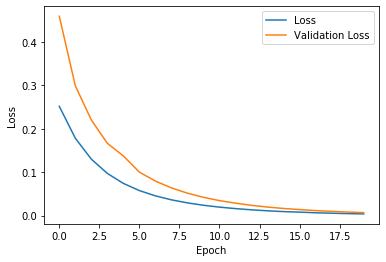

In [42]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [46]:
checkpoint.restore('C:/Users/IVCL/Desktop/NADS_Net/checkpoints/ckpt-4')

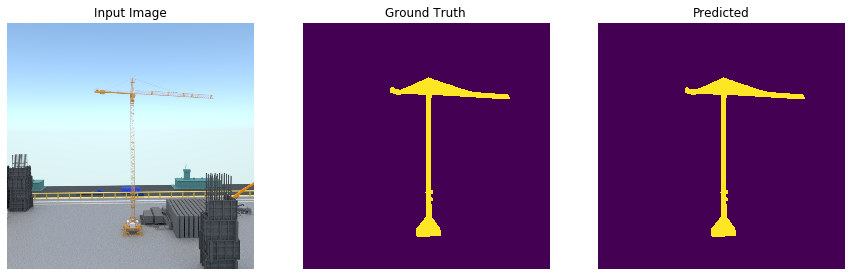

In [47]:
num = 50
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(NADS_Net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


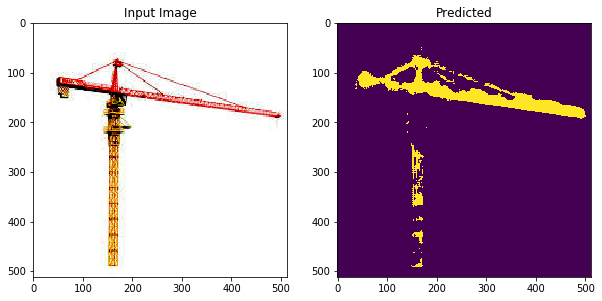

In [48]:
image = read_image('C:/Users/IVCL/Desktop/TowerCrane/train/TC272.jpg')
image = image[tf.newaxis, ...]
prediction = NADS_Net(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()